Mary Jane the Model
==============

***Using machine earning to reveal insights and predict performance of cannabis dispensaries***

**Author:** *Scott Butters*

# Abstract

In 2012, Washington state passed I-502 and legalized the recreational sale, use, and possession of marijuana. This event has led to an explosion of development in the field that's making waves through our society. Since 2014, approximately 500 state licensed dispensaries have opened throughout the state, with nearly 150 of those here in Seattle. And the thing that gets me excited is that because of regulations, a ton of their data is publicly available, meaning I got to play with it. We can go into the weeds later about how and why it took me a thousand websites and 4 different scraping techniques to get the data, and how my R^2 varied when I went shifted from 10-30 features to estimate the monthly revenue of a cannabis dispensary. But for now, let me tell you about what I learned as I immersed myself in this dataset over the past 2 weeks. In this project I scour the web for publicly available data that might be predictive of how a cannabis dispensary performs, such as customer reviews, inventory distributions, and local demographics. I then train machine learning models to predict a dispensary's monthly revenue and analyze the resulting models to distill insights about what drives sales in the marijuana market.


In this project, I explored the question of what makes the Washington recreational cannabis market tick. I decided that if I could identify the features that most contributed to a dispensary's revenue, I could get a lot of insight out of how the features shake out. 

When asked what my project was, I kept saying that it was to use web scraping to predict monthly revenue using linear regression. And it was, of course it was. But that's not the point, that's not the story. 

Here's the monthly revenue of all dispensaries for the last 16 months. See the trend?

Okay. Now. Here's the monthly revenue of a handful of dispensaries over that same period. See the trend?

But we can show this better. Here's the average monthly change in revenue of a dispensary.
Next to the change for the overall market. 
Next to variation in the S&P 500 over the same period.
And now the top marijuana ETF out there.

So if we're going to make choices about what to invest in to make a dispensary successful, we need to have the impacts of the external market in context. So I put those indicators in there for some regression models to see how significant a role they played.

In at attempt to both have more data and isolate the time component of my analysis, I constructed a new target variable, which is marketshare. For each month, I divided the revenue of a given dispensary by the revenue of all of the dispensaries over that period. 

# Obtain the Data

The data for this project is derived from several sources:

## Dispensary profiles from [Leafly](www.leafly.com)

Leafly is an information aggregator for cannabis. They maintain a profile for most of the dispensaries in the state. As part of my dataset, I've scraped the following features from the Leafly website for each dispensary for which it was available:

* Average customer rating and number of customer reviews
* Inventory counts (number of products under descriptions like "flower", "edibles", "concentrates", etc.
* Categorical qualities, such as whether or not the store is ADA accessible or has an ATM onsite
* Metadata such as name, address, phone number, etc.

The combination of these features gives us a profile of each dispensary that allow us to draw insights from our model into what makes for a successful dispensary.

## Demographics from [WA HomeTownLocator](https://washington.hometownlocator.com/)

Of course, having the best inventory, friendliest staff and prettiest building in the state doesn't amount to anything if a dispensary is in the middle of nowhere. This is where demographic data comes in. WA HomeTownLocator maintains a database of demographic statistics for nearly every zip code in the state of Washington. The data is produced by Esri Demographics, and updated 4 times per year using data from the federal census, IRS, USPS, as well as local data sources and more. From this website I scraped data likely to be predictive of a local market such as:

* Population density
* Diversity
* Average income

These data give our model an image of what a dispensary's customer base is like, allowing us to characterize what makes for a good location to establish a dispensary.

## [Washington State Liquor and Cannabis Board (WSLCB)](https://lcb.wa.gov/)

Lastly, all that data would get us nowhere if we didn't have any target data to train our models on. That's where the WSLCB comes in. The WSLCB maintains data on every dispensary in the state, including monthly reports of revenue (which is what our model is predicting). Their data is scattered across a couple of different outlets, but for this project I used spreadsheets downloadable from [this obsure page](https://lcb.wa.gov/records/frequently-requested-lists) to get sales data dating back to November 2017. Because the only identifying information in that spreadsheet is the license number of the dispensary, I also downloaded a spreadsheet listing metadata for every entity that has applied for a Marijuana license, which I then joined with the sales data in order to link it up with data scraped from other resources.

## Data Collection

The code below contains a pipeline to visit each of our sources and scrape or download all of the desired data into a few files stored in the data/raw/ directory to be scrubbed and processed later.

In [999]:
## %%writefile ../src/data/make_dataset.py

# Imports
import json
import os
import random
import re
import requests
import sys
import time

import numpy as np
import pandas as pd

from fake_useragent import UserAgent
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By

# Helper functions
def parse_products(text):
    '''
    Parses string of products into dictionary of products with counts
    Input: string of products as scraped from Leafly dispensary page
    Output: dictionary of {product: count} relationships
    '''
    repl = ['(', ')']
    for char in repl:
        text = text.replace(char, '')
    prod_list = text.split('\n')
    prod_list = [prod.strip().lower() for prod in prod_list]
    prod_dict = {}
    for i, element in enumerate(prod_list):
        if element.isnumeric():
            prod_dict[prod_list[i - 1]] = int(element)
        elif 'difference' in element:
            pass
        else:
            prod_dict[element.strip()] = 0
    return prod_dict


def scrape_disp(disp, driver, user_agent):
    """
    Scrapes dispensary-specific page on leafly for additional data and adds it
    to existing dictionary dataset
    Input: dictionary containing metadata for a single dispensary
    Output: dictionary with additional metadata for given dispensary
    """
    url = 'https://www.leafly.com/dispensary-info/'
    slug = disp['slug']
    url += slug
    name = disp['name']
    if 'OR' in disp['formattedShortLocation']:
        return {}
    
    response  = requests.get(url, headers=user_agent)
    if not response.ok:
        print(f'Connection to {name} failed')
        return {}
    
    # Open page
    driver.get(url)
    
    # Confirm over 21
    try:
        yes_button = driver.find_element_by_xpath('//button[text()="Yes"]')
        yes_button.click()
    except:
        pass

    # Scrape categoricals
    try:
        cat_selector = driver.find_element_by_class_name('jsx-4153842418')
        # cat_selector = driver.find_element_by_tag_name('ul')
        items = cat_selector.find_elements_by_tag_name("li")
        categories = {item.text.lower(): True for item in items}
        disp.update(categories)
    except:
        print(f'Failed to scrape categories for {name}')
        pass

    # Scrape products
    try:
        products = driver.find_elements_by_class_name('jsx-1433915045')
        products_text = products[0].text
        product_dict = parse_products(products_text)
        disp.update(product_dict)
    except:
        print(f'Failed to scrape products for {name}')
        pass
    
    # Scrape zip
    try:
        element = driver.find_element(by=By.ID, value="__NEXT_DATA__")
        htmlCode = driver.execute_script(
            "return arguments[0].innerHTML;", element)
        d = json.loads(htmlCode)
        zip_code = d['props']['pageProps']['dispensary']['zip']
        disp.update({'zip': zip_code})
    except:
        print(f'Failed to scrape zip for {name}')
        pass
    
    print(f'Successfully scraped {name}')
    return disp


def scrape_leafly_disps(path, disp_data_filename, data):
    """
    Gets JSON file of data on dispensaries from Leafly, either by loading
    pre-existing file or by re-scraping Leafly
    Input: path and filename for output file, index  of basic dispensary metadata
    Output: Index formatted JSON with one dictionary for each found dispensary
    """
#     filepath = '../data/raw/dispensary_data.json'
    filepath = path + disp_data_filename
    if os.path.isfile(filepath):
        overwrite = input(
            '''Dispensaries data dict already exists. Scrape data again? y/n\n
            Note: this could take several minutes.''')
        if overwrite.lower() != 'y':
            with open(filepath) as json_file:
                data = json.load(json_file)
            return data

    print("Beginning scrape...")
    ua = UserAgent()
    user_agent = {'User-agent': ua.random}
    chromedriver = "/Applications/chromedriver"
    os.environ["webdriver.chrome.driver"] = chromedriver
    driver = webdriver.Chrome(chromedriver)

    for disp in data:
        new_data = scrape_disp(data[disp], driver, user_agent)
        data[disp].update(new_data)
    
    with open(filepath, 'w') as outfile:  
        json.dump(data, outfile)
        print('Scraped data written to {}'.format(filepath))
    
    return data


def retry(TL_lat, TL_lon, cell_size):
    '''
    If request hits Leafly API limit, split cell into 4 subcells and retry
    Input: Lat/lon coordinates for top left of map and optionally a size for
    the map area (defaults to 0.5)
    Output: dictionary of dictionaries containing metadata for each dispensary 
    found in map area
    '''
    TL_lats = [TL_lat, TL_lat - 0.4 * cell_size]
    TL_lons = [TL_lat, TL_lat + 0.4 * cell_size]
    disp_data = {}
    for lat, lon in zip(TR_lats, TR_lons):
        data = get_disp_data_by_coords(lat, lon, cell_size=0.6 * cell_size)
        disp_data.update(data)
    return disp_data


def get_disp_data_by_coords(TL_lat, TL_lon, cell_size=0.5):
    """
    Performs search for all dispensaries within a map region on Leafly
    Input: Lat/lon coordinates for top left of map and optionally a size for
    the map area (defaults to 0.5)
    Output: dictionary of dictionaries containing metadata for each dispensary 
    found in map area
    """
    # Setup
    BR_lat = TL_lat - cell_size
    BR_lon = TL_lon + cell_size
    coords = TL_lat, TL_lon, BR_lat, BR_lon
    
    url = (
        'https://web-finder.leafly.com/api/searchThisArea?topLeftLat={}&topLeftLon={}&bottomRightLat={}&bottomRightLon={}&userLat=47.6&userLon=-122.3'
        ).format(TL_lat, TL_lon, BR_lat, BR_lon)
    
    # Scrape
    time.sleep(.5+2*random.random())
    r = requests.get(url)
    if r.status_code != 200:
        print('Leafly search failed at {}'.format(coords))
        return {}
    disps = r.json()
    
    # Parse
    fields = ['name', 'address1', 'address2', 'city', 'location', 'phone',
              'formattedShortLocation', 'medical', 'recreational', 'tier', 
              'lastMenuUpdate', 'starRating', 'numberOfReviews', 'slug']

    disp_data = {
        d['name']: {k: d[k] for k in fields} for d in disps['dispensaries']}
    entries = len(disp_data)
    
    # Check results; retry if necessary and return data
    if entries > 200:
        return retry(TR_lat, TR_lon, cell_size)
    elif entries < 1:
#         print('no results at {}'.format(coords))
        return {}
    else:
#         print('{} results found at {}'.format(len(disp_data), coords))
        return disp_data
    
    
def get_rect_disp_data(TL_lat, TL_lon, BR_lat, BR_lon, cell_size=0.5):
    """
    Performs grid search on sub-rectangles with slight overlap, gathering data 
    on each cell
    Input: lat/lon coords of top left and bottom right corners, as well as 
    optional cell size parameter (defaults to 0.5)
    Output: dictionary of dictionaries representing all dispensaries in
    rectangle
    """
    coords = TL_lat, TL_lon, BR_lat, BR_lon
    max_step = 0.8 * cell_size
    lat_steps = np.ceil((TL_lat - BR_lat - cell_size) / max_step)
    lon_steps = np.ceil((BR_lon - TL_lon - cell_size) / max_step)

    TL_lats = np.linspace(TL_lat, BR_lat + cell_size, lat_steps + 1)
    TL_lons = np.linspace(TL_lon, BR_lon - cell_size, lon_steps + 1)

    disp_data = {}

    for lat in TL_lats:
        for lon in TL_lons:
            data = get_disp_data_by_coords(lat, lon, cell_size)
            disp_data.update(data)

    print('Total dispensaries found: ', len(disp_data))
    return disp_data


def get_disp_dict(path):
    """
    Performs a grid search across Washington for all dispensaries with an
    account on Leafly and scrapes metadata for each
    Input: relative path to raw data directory
    Output: Index formatted JSON with one dictionary for each found dispensary
    """
    filepath = path + 'dispensary_list.json'
    
    if os.path.isfile(filepath):
        overwrite = input(
            '''Initial dispensary list already exists. Scrape data again? y/n\n 
            Note: this could take several minutes.''')
        if overwrite.lower() != 'y':
            with open(filepath) as json_file:
                data = json.load(json_file)
            return data
    print("Beginning scrape...")
    
    # WA State bounding coordinates
    north = 49
    west = -124.8
    south = 45.4
    east = -116.8
    
    data = get_rect_disp_data(north, west, south, east, cell_size=1.4)
    
    with open(filepath, 'w') as outfile:  
        json.dump(data, outfile)
        print('Scraped data written to {}'.format(filepath))
        
    return data


def get_leafly_disp_data(path, disp_filename):
    """
    Steps through all helper functions to scrape data from Leafly
    Input: raw data path and desired filename for output
    Output: JSON file containing scraped data
    """
    disp_dict = get_disp_dict(path)
    disp_data = scrape_leafly_disps(path, disp_filename, disp_dict)
    return


def get_demo_data(path, license_filename, demo_filename):
    """
    Scrapes zip code based demographic data from washington.hometownlocator.com
    for all zip codes containing a dispensary found in WSLCB license data
    Input: relative path to raw data directory, license data filename, 
    demographics data filename
    Output: saves demographic dataset to csv in raw data directory
    """
    license_filepath = path + license_filename
    demo_filepath = path + demo_filename

    if os.path.isfile(demo_filepath):
        overwrite = input(
            '''Demographics file already exists. Scrape data again? y/n\n 
            Note: this could take several minutes.''')
        if overwrite.lower() != 'y':
            return
    
    license_data = pd.read_excel(license_filepath, sheet_name=2, header=0)
    zips = license_data['ZipCode'].astype(str).str[:5].unique()
    demographics = pd.DataFrame()
    
    print("Beginning scrape...")
    for zip_code in sorted(zips):
        url = f'https://washington.hometownlocator.com/zip-codes/data,zipcode,{zip_code}.cfm'
        r = requests.get(url)
        if 'table' in r.text:
            df0, df1 = pd.read_html(url, index_col=0)[:2]
            df0.columns = [str(zip_code)]
            df1.columns = [str(zip_code)]
            df = pd.concat([df0, df1], axis=0).T.dropna(axis=1)
            df.drop(['INCOME', 'HOUSEHOLDS'], axis=1, inplace=True)
            demographics = pd.concat([demographics, df])
            print('Scraped {}/{} zips. Latest: {}'
                  .format(len(demographics), len(zips), zip_code), end='\r')
            sys.stdout.flush()
        else:
            print(f'\nNo data found for {zip_code}')
        
    demographics.to_csv(demo_filepath)
    print('Scraped data written to {}'.format(demo_filepath))
    return
    
    
def download_dataset(url, path, filename):
    """
    Downloads dataset from specified url and saves file to raw data directory
    Input: url from which to retrieve data, filename to store data in
    Output: dataset stored in raw data file directory
    """
#     filepath = '../data/raw/{}'.format(filename)
    filepath = path + filename
    file_exists = os.path.isfile(filepath)
    if file_exists:
        overwrite = input('{} already exists. Update? y/n'.format(filename))
        if overwrite.lower() != 'y':
            return
    print("Beginning file download...")
    r = requests.get(url)
    if not r.ok:
        print('Download failed')
        return
    with open(filepath, 'wb') as f:  
        f.write(r.content)
    print('File written to {}\n'.format(filepath))
    return
    
    
def get_sales_data(path, sales_filename, license_filename):
    """
    Gets links for most up-to-date dispensary sales and license information
    from WSLCB and downloads datasets
    Input:
    Output: downloaded files to raw data directory
    """
    # Get urls for most up-to-date sales and license data
    url = 'https://lcb.wa.gov/records/frequently-requested-lists'
    response = requests.get(url)
    if response.ok:
        soup = BeautifulSoup(response.text, "html.parser")
        links = soup.find_all('a')
        for link in links:
            if 'Traceability' in link.text:
                sales_url = link['href']
                print(f'\nLatest sales data found:\n{sales_url}')
                #filename = 'sales_data.xlsx'
                download_dataset(sales_url, path, sales_filename)
            elif 'Applicants' in link.text:
                licenses_url = link['href']
                print(f'\nLatest license data found:\n{licenses_url}')
                #filename = 'license_data.xls'
                download_dataset(licenses_url, path, license_filename)
    else:
        print('Failed to download sales data')

    return

    
def run():
    """
    Executes a set of helper functions that download data several
    sources and saves those datasets to the data/raw directory.
    """
    path = '../data/raw/'
    
    sales_filename = 'sales_data.xlsx'
    license_filename = 'license_data.xls'
    demo_filename = 'demographics.csv'
    disp_filename = 'dispensary_data.json'
    
    get_sales_data(path, sales_filename, license_filename)
    get_demo_data(path, license_filename, demo_filename)
    get_leafly_disp_data(path, disp_filename)
    
    print('\nData acquisition complete.\n')
    return

In [1000]:
run()


Latest license data found:
https://lcb.wa.gov/sites/default/files/publications/Public_Records/2019/MarijuanaApplicants.xls
license_data.xls already exists. Update? y/ny
Beginning file download...
File written to ../data/raw/license_data.xls


Latest sales data found:
https://lcb.wa.gov/sites/default/files/publications/Marijuana/sales_activity/2019-04-10-MJ-Sales-Activity-by-License-Number-Traceability-Contingency-Reporting.xlsx
sales_data.xlsx already exists. Update? y/ny
Beginning file download...
File written to ../data/raw/sales_data.xlsx

Demographics file already exists. Scrape data again? y/n
 
            Note: this could take several minutes.n
Initial dispensary list already exists. Scrape data again? y/n
 
            Note: this could take several minutes.y
Beginning scrape...


/anaconda3/envs/project2/lib/python3.7/site-packages/ipykernel_launcher.py:222: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
/anaconda3/envs/project2/lib/python3.7/site-packages/ipykernel_launcher.py:223: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


Total dispensaries found:  635
Scraped data written to ../data/raw/dispensary_list.json
Dispensaries data dict already exists. Scrape data again? y/n

            Note: this could take several minutes.y
Beginning scrape...
Failed to scrape products for Mister Buds
Successfully scraped Mister Buds
Successfully scraped Origins Port Angeles
Failed to scrape products for Cannabis Coast
Successfully scraped Cannabis Coast
Successfully scraped The Green Room - Oak Harbor
Failed to scrape products for The Pot Shop Bellingham
Successfully scraped The Pot Shop Bellingham
Successfully scraped Kaleafa Cannabis Co. - Oak Harbor
Failed to scrape products for Karma Cannabis
Successfully scraped Karma Cannabis
Successfully scraped Have a Heart - Greenwood
Successfully scraped American Mary - Ballard - Grand Opening!
Failed to scrape products for The Original FARM - Victoria, Hillside
Successfully scraped The Original FARM - Victoria, Hillside
Successfully scraped Better Buds - Silverdale
Failed to sc

Successfully scraped The Vault - Stanwood
Successfully scraped Floyd's Cannabis Co. - Sedro-Woolley
Successfully scraped Theorem Cannabis - Kenmore
Successfully scraped A Greener Today - Bothell
Failed to scrape products for The Evergreen Market - Kirkland - COMING SOON
Successfully scraped The Evergreen Market - Kirkland - COMING SOON
Successfully scraped Always Greener Downtown - Redmond
Successfully scraped Euphorium in Lynnwood
Successfully scraped The Last Stop Pot Shop - Gold Bar
Successfully scraped Origins - Redmond
Successfully scraped Have a Heart - Lake Forest Park
Failed to scrape products for Marijuana Club 99
Successfully scraped Marijuana Club 99
Successfully scraped Local Roots - Everett
Successfully scraped PRC - Arlington
Successfully scraped Green Lady - Lynnwood
Failed to scrape products for Smuggler Brothers - Recreational
Successfully scraped Smuggler Brothers - Recreational
Successfully scraped Bud Hut - Snohomish
Successfully scraped WCW / West Coast Wellness - 

Failed to scrape products for World of Weed - Tacoma
Successfully scraped World of Weed - Tacoma
Failed to scrape products for 420 Capitol
Successfully scraped 420 Capitol
Successfully scraped Emerald Coast Cannabis
Failed to scrape products for The Green Door - Seattle
Successfully scraped The Green Door - Seattle
Successfully scraped Tacoma House of Cannabis
Failed to scrape products for Legal Marijuana Superstore - Recreational
Successfully scraped Legal Marijuana Superstore - Recreational
Failed to scrape products for The Root Cellar - Recreational
Successfully scraped The Root Cellar - Recreational
Successfully scraped Mr. O.G. - Seattle
Successfully scraped The Joint - SeaTac Airport
Failed to scrape products for THC - Olympia
Successfully scraped THC - Olympia
Failed to scrape products for Uncle Ike's - White Center
Successfully scraped Uncle Ike's - White Center
Failed to scrape products for Ganja Vita
Successfully scraped Ganja Vita
Failed to scrape products for Bud Barn
Succe

Failed to scrape products for Satori - Pullman
Successfully scraped Satori - Pullman
Failed to scrape products for MJ's Pot Shop
Successfully scraped MJ's Pot Shop
Successfully scraped Kush21 - Pullman
Failed to scrape products for Bud Hut - Pullman
Successfully scraped Bud Hut - Pullman
Failed to scrape products for Lucid - Cheney
Successfully scraped Lucid - Cheney
Successfully scraped Floyd's Cannabis Co. - Pullman
Successfully scraped Freedom Market Ilwaco - Recreational
Successfully scraped Mr. Doobees - Natural High Store
Successfully scraped Cannabis Country Store - Vancouver, Battle Ground
Successfully scraped The Herbery - Chkalov
Successfully scraped The Herbery - 164th
Successfully scraped High 5 Cannabis
Successfully scraped Tru Greenthumb - Castle Rock
Failed to scrape products for Bud Hut - Vancouver
Successfully scraped Bud Hut - Vancouver
Successfully scraped Localamster in Longview
Successfully scraped Greenhead Cannabis - Vancouver
Successfully scraped High End Market

# Scrub the Data

*Look through the raw data files and see what you will need to do to them in order to have a workable data set. If your source data is already well-formatted, you may want to ask yourself why it hasn't already been analyzed and what other people may have overlooked when they were working on it. Are there other data sources that might give you more insights on some of the data you have here?*

*The end goal of this step is to produce a [design matrix](https://en.wikipedia.org/wiki/Design_matrix), containing one column for every variable that you are modeling, including a column for the outputs, and one row for every observation in your data set. It needs to be in a format that won't cause any problems as you visualize and model your data.*

In [ ]:
## %%writefile ../src/features/build_features.py
# !pip install fuzzywuzzy
# !pip install python-Levenshtein

# Imports
import json
import re

import numpy as np
import pandas as pd

from fuzzywuzzy import fuzz 
from fuzzywuzzy import process

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.impute import SimpleImputer

import geopy.distance

## Walkscore Dev

In [1032]:
def get_walkscore_url(address, city, zip_code, lat, lon):
    
    api_key = '466d1cb991e8a99345b049d505c6a4a7'
    
    base_url = 'http://api.walkscore.com/score?format=json'
    mid_url = 'transit=1&bike=1'
    address = 'address=' + '%'.join(address.split())
    address = '%20'.join([address, city, 'WA', zip_code])
    lat = f'lat={lat}'
    lon = f'lon={lon}'
    api_key = f'wsapikey={api_key}'
    url = '&'.join([base_url, address, lat, lon, mid_url, api_key])
    return url

address = '1119 8th Avenue'
city = 'Seattle'
zip_code = '98101'
lat = 47.6085
lon = -122.3295

get_walkscore_url(address, city, zip_code, lat, lon)
    
# """
# http://api.walkscore.com/score?format=json&
# address=1119%8th%20Avenue%20Seattle%20WA%2098101
# &lat=47.6085
# &lon=-122.3295
# &transit=1&bike=1&wsapikey=<YOUR-WSAPIKEY>
# """

'http://api.walkscore.com/score?format=json&address=1119%8th%Avenue%20Seattle%20WA%2098101&lat=47.6085&lon=-122.3295&transit=1&bike=1&wsapikey=466d1cb991e8a99345b049d505c6a4a7'

In [1033]:
url = get_walkscore_url(address, city, zip_code, lat, lon)
r = requests.get(url)

In [1039]:
pprint(r.text)

('{\n'
 '"status": 1  \n'
 ', "walkscore": 99\n'
 ', "description": "Walker\'s Paradise"\n'
 ', "updated": "2018-11-09 18:29:55.581614" \n'
 ', "logo_url": "https://cdn.walk.sc/images/api-logo.png"\n'
 ', "more_info_icon": "https://cdn.walk.sc/images/api-more-info.gif"\n'
 ', "more_info_link": "https://www.redfin.com/how-walk-score-works"\n'
 ', "ws_link": '
 '"https://www.walkscore.com/score/1119-8th-Avenue-20Seattle-20WA-2098101/lat=47.6085/lng=-122.3295/?utm_source=botscutters.github.io '
 '&utm_medium=ws_api&utm_campaign=ws_api"\n'
 ', "help_link": "https://www.redfin.com/how-walk-score-works"\n'
 ', "snapped_lat": 47.6085\n'
 ', "snapped_lon": -122.3295 \n'
 '\n'
 '\n'
 '\n'
 ', "transit" : {"score": null, "description": null, "summary": null} \n'
 ', "bike" : {"score": 79, "description": "Very Bikeable"} \n'
 '}')


In [1050]:
test = pd.read_pickle('../data/interim/leafly.pkl')
row = test.iloc[4]
fields = ['address1', 'city', 'zip_code', 'latitude', 'longitude']
address, city, zip_code, lat, lon = row[fields]
url = get_walkscore_url(address, city, zip_code, lat, lon)
r = requests.get(url)

In [1056]:
fields = ['address1', 'city', 'zip_code', 'latitude', 'longitude']
address, city, zip_code, lat, lon = row[fields]
url = get_walkscore_url(address, city, zip_code, lat, lon)
r = requests.get(url)

response = json.loads(r.text)

bikescore = response['bike']['score']
walkscore = response['walkscore']
transit_score = response['transit']['score']

{'bike': {'description': 'Bikeable', 'score': 67},
 'description': 'Very Walkable',
 'help_link': 'https://www.redfin.com/how-walk-score-works',
 'logo_url': 'https://cdn.walk.sc/images/api-logo.png',
 'more_info_icon': 'https://cdn.walk.sc/images/api-more-info.gif',
 'more_info_link': 'https://www.redfin.com/how-walk-score-works',
 'snapped_lat': 48.759,
 'snapped_lon': -122.463,
 'status': 1,
 'transit': {'description': None, 'score': None, 'summary': None},
 'updated': '2018-10-22 00:59:49.073591',
 'walkscore': 76,
 'ws_link': 'https://www.walkscore.com/score/2119-Lincoln-St-20Bellingham-20WA-2098225/lat=48.7582703/lng=-122.4626084/?utm_source=botscutters.github.io '
            '&utm_medium=ws_api&utm_campaign=ws_api'}


In [1073]:
coords = ['latitude', 'longitude']
data[coords]

KeyError: "None of [Index(['latitude', 'longitude'], dtype='object')] are in the [columns]"

In [1123]:
def get_nearby_disps(lat, lon, df, radius):
    """
    Compute the number of dispensaries within some distance of target disp
    Input: lat and lon of target disp, df containing other disps, target radius 
    in miles
    Output: Number of dispensaries within target distance (int)
    """
    lat_deg_mile = 0.02116
    lon_deg_mile = 0.01447
    
    lat_filter = np.abs(df['latitude'] - lat) < lat_deg_mile * radius
    lon_filter = np.abs(df['longitude'] - lon) < lon_deg_mile * radius
    return df[lat_filter & lon_filter].shape[0] - 1


def build_features(path, filename):
    """
    make composite features that account for features existing
    """
    inpath = path['interim'] + filename['int_joined']
    outpath = path['processed'] + filename['processed']
    data = pd.read_pickle(inpath)

    products = ['accessories', 'all_products', 'cartridges', 'concentrates', 
                'edibles', 'flower', 'other', 'prerolls', 'seeds', 'topicals']

    # Add flag indicating whether dispensary has menu on Leafly profile
    data['leafly_menu'] = data[products].sum(axis=1) > 0

    # Categoricals
    debit = ['atm', 'debit_cards_accepted']
    data['debit_available'] = data[debit].sum(axis=1) > 0
    drop_cols = debit
    discounts = ['ufcw_discount', 'veteran_discount']
    data['discounts'] = data[discounts].sum(axis=1) > 0
    drop_cols += discounts

    # Lump all low-count Leafly features (along with other) into misc column
    counts = data[products].count()
    low_counts = [p for p in counts.index if counts[p] < 0.25 * len(data)]
    if 'other' not in low_counts:
        low_counts.append('other')
    data['misc'] = data[low_counts].sum(axis=1)
    drop_cols += low_counts
    
    # Assuming data is arranged in the order it was collected, this will
    # approximately give a dispensary a value similar to those it's
    # geographically near to. Would be better if it checked that in a robust
    # way. Update later.
    prods =['all_products', 'concentrates', 'edibles', 'flower', 'prerolls', 'misc']
    data[prods] = data[prods].interpolate()
    
    # Interpolate walkscores
    walkscores = ['bike_score', 'walk_score', 'transit_score']
    data[walkscores] = data[walkscores].interpolate()
    
    # Fill nans with mean
    fill_cols = [
        'total_population', 'population_in_households', 'population_in_familes',
        'population_in_group_qrtrs', 'population_density', 'diversity_index',
        'median_household_income', 'average_household_income',
        'per_capita_income', 'median_home_value', 'average_home_value',
        'total_households', 'average_household_size', 'family_households',
        'average_family_size', 'total_housing_units_#',
        'owner_occupied_housing_units_#', 'owner_occupied_housing_units_%',
        'renter_occupied_housing_units_#', 'renter_occupied_housing_units_%',
        'vacant_housing_units_#', 'vacant_housing_units_%',
        'bike_score', 'walk_score']
    imp_mean = SimpleImputer()
    data[fill_cols] = imp_mean.fit_transform(data[fill_cols])

    # Days since last menu update and since license issued
    dates = ['reporting_period', 'last_menu_update', 'date_issued']
    days = ['days_since_update', 'days_since_license']
    data[days[0]] = data[dates[0]].dt.day - data[dates[1]].dt.day
    data[days[1]] = data[dates[0]].dt.day - data[dates[2]].dt.day
    data[days] = data[days].fillna(data[days].median())
    
    # Calculate number of dispensaries within various distances of each disp
    radii = [2, 5, 10, 20]
    dist_cols = [f'disps_within_{r}_mi' for r in radii]
    cols = ['latitude', 'longitude']
    for r, c in zip(radii, dist_cols):
        data[c] = [get_nearby_disps(x, y, data, r) 
                   for x, y in zip(data[cols[0]], data[cols[1]])]
        
    # Log transforms
    log_col = [
        'total_sales', 'all_products', 'concentrates', 'edibles', 'flower', 
        'prerolls', 'misc', 'number_of_reviews', 'population_in_group_qrtrs', 
        'population_density'] + dist_cols
    for col in log_col:
        temp = np.log10(data[col])
        temp[temp == -np.inf] = 0
        data['_'.join(['log', col])] = temp
        
    # Convert rating to log(-(x-5))
    data['log_star_rating'] = np.log10(5.05 - data['star_rating'])
    
    # Drop unused cols
    drop_cols += dates
    drop_cols += ['excise_tax_due', 'latitude', 'longitude', 
                  'total_housing_units_%', 'transit_score']
    data.drop(labels=drop_cols, axis=1, inplace=True)
    
    data.to_pickle(outpath)
    
    return data


def clean_joined_data(data):
    """
    Final clean of joined dataframe prior to feature engineering.
    Input: freshly joined dataframe
    Output: trimmed and cleaned dataframe retaining only elements that will be
    useful for building features and targets
    """
    # Drop rows and columns that are no longer useful
    data.dropna(axis=0, subset=['matched_key'], inplace=True)
    cols = [
        'name_x', 'address1_x', 'privdesc', 'phone_x', 'key_x', 'state',
        'county', 'address1_y', 'phone_y', 'slug', 'key_y', 'matched_key', 
        'score', 'city_x', 'zip_code', 'city_y', 'privilegestatus']
    data.drop(columns=cols, inplace=True)

    data.rename(columns={'name_y': 'name'}, inplace=True)
    data.set_index(keys='name', drop=True, inplace=True)
    
    return data
    

def make_key(row, fields):
    """
    Constructs a key from a simplified composite of a dispensary's name, city,
    and address
    Input: dataframe row (from apply function) along with a list of names of 
    fields to get key information from
    Output: lowercase string containing unique tokens from each of the fields 
    with punctuation removed and commonly shortened terms abbreviated
    """
    items = [row[f] for f in fields if isinstance(f, str)]
    joined = ' '.join(items).lower()
    remove = list('!@#$%^&*()-_+,./<>?[]{}')
    for char in remove:
        joined = joined.replace(char, '')
    
    abbr = {'street': 'st',
            'road': 'rd',
            'drive': 'dr',
            'highway': 'hwy',
            'avenue': 'ave',
            'boulevard': 'blvd',
            'suite': 'ste',
            'lane': 'ln',
            'northeast': 'ne',
            'southeast': 'se',
            'southwest': 'sw',
            'northwest': 'nw',
            'state route': 'sr',
            'llc': '',
            'wa20': 'sr 20',
            'us101': 'hwy 101',
            'wa14': 'hwy 14',
            'wa99': 'hwy 99',
            'stevens pass hwy': 'stevens pass hwy sr 2',
            'us395': 'hwy 395'
           }
    
    for token in abbr:
        joined = joined.replace(token, abbr[token])
    key = ' '.join(list(joined.split()))
    return key


def match_key(row, df, threshhold=70):
    """
    Uses fuzzy logic to find the closest matching key from a list of keys and
    the best match along with a score if above a specified threshhold
    Input: row of dataframe containing a key, dataframe containing column of
    target keys to match to, and optionally a threshhold specification, which
    is set to 65 by default
    Output: A tuple of the form (best_match_key, score). If no key surpasses
    the threshhold, (np.nan, max_score) is returned.
    """
    key = row['key']
    candidates = df['key']
    max_score = -1
    max_name = ""
    
    for f_key in candidates:
        score = fuzz.token_sort_ratio(key, f_key)
        if (score > threshhold) & (score > max_score):
            max_name = f_key
            max_score = score
    if max_score < threshhold:
        return (np.nan, max_score)
    return (max_name, max_score)


def get_walkscore_url(address, city, zip_code, lat, lon):
    """
    Construct url for Walkscore api call
    Input: address, city, and zip_code as strings; lat/lon coords as float
    Output: prepared url to request walkscore for address
    """
    api_key = '466d1cb991e8a99345b049d505c6a4a7'
    base_url = 'http://api.walkscore.com/score?format=json'
    mid_url = 'transit=1&bike=1'
    address = 'address=' + '%'.join(address.split())
    address = '%20'.join([address, city, 'WA', zip_code])
    lat = f'lat={lat}'
    lon = f'lon={lon}'
    api_key = f'wsapikey={api_key}'
    url = '&'.join([base_url, address, lat, lon, mid_url, api_key])
    return url


def get_walkscores(row):
    """
    Makes api call to Walkscore and extracts bike, walk, and transit scores
    Input: dataframe row containing required fields
    Output: list containing bike, walk, and transit scores (or nan, if failure)
    """
    fields = ['address1', 'city', 'zip_code', 'latitude', 'longitude']
    address, city, zip_code, lat, lon = row[fields]
    url = get_walkscore_url(address, city, zip_code, lat, lon)
    
    try:
        r = requests.get(url)
        response = json.loads(r.text)

        bike_score = response['bike']['score']
        walk_score = response['walkscore']
        transit_score = response['transit']['score']
    except:
        return (np.nan, np.nan, np.nan)
    return [bike_score, walk_score, transit_score]
    

def join_cleaned_data(path, filename):
    """
    Join all cleaned data into a single dataframe and pickle
    Input: dictionaries containing paths and filenames for input/output files
    Output: pickled dataframe of all of the cleaned data
    """
    names = ['int_leafly', 'int_sales', 'int_demo']
    filepaths = [path['interim'] + filename[n] for n in names]
    leafly, sales, demo = [pd.read_pickle(f) for f in filepaths]
    outpath = path['interim'] + filename['int_joined']

    # Get Walkscores
    walkscores = ['bike_score', 'walk_score', 'transit_score']
    overwrite = input(
        '''Walkscore API only allows 5000 requests per day. Scrape data again?
        y/n: \n
        Note: this could take several minutes...''')
    if overwrite.lower() == 'y':
        leafly[walkscores] = leafly.apply(get_walkscores, axis=1, 
                                          result_type='expand')
    else:
        leafly[walkscores] = pd.read_pickle(outpath)[walkscores]
    
    # Construct composite key for joining with sales data
    key_fields = ['city', 'address1', 'zip_code']
    leafly['key'] = leafly.apply(make_key, axis=1, fields=key_fields)
    sales['key'] = sales.apply(make_key, axis=1, fields=key_fields)

    leafly[['matched_key', 'score']] = leafly.apply(
        match_key, axis=1, df=sales).apply(pd.Series)
    leafly = leafly.drop(columns=['zip_code'])
    
    # Merge leafly data into sales data
    data = pd.merge(
        sales, leafly, how='left', left_on='key', right_on='matched_key')

    ## merge demo data into sales data
    data = pd.merge(data, demo, how='left', on='zip_code')
    
    data = clean_joined_data(data)
    
    data.to_pickle(outpath)
    return data


def join_sales_data(path, filename):
    """
    Loads sales and license data files and joins them into one table
    Also creates a column with zip code as a 5 digit string for later use
    Input:
    Output: returns merged dataframe
    """
    filepath = path['raw'] + filename['raw_sales']
    sales_data = pd.read_excel(filepath, sheet_name=0, header=3)
    sales_data.rename(columns={'License Number':'License #'}, inplace=True)
    sales_data.set_index(keys='License #', inplace=True)

    filepath = path['raw'] + filename['raw_license']
    license_data = pd.read_excel(filepath, sheet_name=2, header=0, index_col=1)

    data = pd.merge(sales_data, license_data, how='left', on='License #')
    return data  

    
def clean_wslcb_data(path, filename):
    """
    Loads, cleans, and joins raw license and sales data from WSLCB.
    Input: dictionaries containing paths and filenames for input/output files
    Output: a cleaned and pickled dataframe of data from WSLCB
    """
    data = join_sales_data(path, filename)
    data.columns = data.columns.str.lower().str.replace(' ', '_')
    data.rename(columns={
        'tradename': 'name', 
        'dateissued': 'date_issued',
        'dayphone': 'phone',
        'street_address': 'address1'
    }, inplace=True)

    data['zip_code'] = data['zipcode'].astype(str).str[:5]
    data['phone'] = data['phone'].astype(str).str[:-2]
    data['name'] = data['name'].str.strip().str.lower()

    data['reporting_period'] += '-01'
    date_cols = ['reporting_period', 'date_issued']
    for col in date_cols:
        data[col] = pd.to_datetime(data[col], errors='coerce', yearfirst=True,
                                   infer_datetime_format=True)

    # Average monthly revenue over past quarter
    quarter = data['reporting_period'] > '2018-11-30'
    quarterly_sales = data[quarter].groupby(by='License #').mean()['total_sales']
    recent = data['reporting_period'] == data['reporting_period'].max()
    data = data[recent]
    data['total_sales'] = quarterly_sales
    # And drop ultra-low outliers
    low_f = data['total_sales'] > 10000
    data = data[low_f]

    # Drop old columns we don't want anymore
    cols = ['ubi', 'suite/rm', 'zipcode']
    data.drop(columns=cols, inplace=True)
    
    # Drop rows without names
    data.dropna(subset=['name'], inplace=True)
    
    outpath = path['interim'] + filename['int_sales']
    data.to_pickle(outpath)
    return

    
def clean_demographic_data(path, filename):
    """
    Loads and cleans raw demographic data.
    Input: dictionaries containing paths and filenames for input/output files
    Output: a cleaned and pickled dataframe of demographic
    """
    raw_filename = path['raw'] + filename['raw_demo']
    int_filename = path['interim'] + filename['int_demo']

    data = pd.read_csv(raw_filename)

    # Reformat column
    data.columns = data.columns.str.lower().str.replace(' ', '_')
    data.rename(columns={
        'unnamed:_0': 'zip_code', 
        'population_density2': 'population_density',
        'diversity_index3': 'diversity_index',
        'owner_occupied_hu': 'owner_occupied_housing_units',
        'renter_occupied_hu': 'renter_occupied_housing_units'
    }, inplace=True)
    data['zip_code'] = data['zip_code'].astype(str)
    data.set_index('zip_code', drop=True, inplace=True)

    # Reformat columns with dollar strings into ints
    cols = ['median_household_income', 'average_household_income',
            'per_capita_income', 'median_home_value', 'average_home_value']
    for c in cols:
        data[c] = data[c].str.replace('$', '').str.replace(',', '').astype(int)

    # Split columns with number and percent values into separate columns
    cols = ['total_housing_units', 'owner_occupied_housing_units', 
            'renter_occupied_housing_units', 'vacant_housing_units']
    new_cols = {col:[f'{col}_#', f'{col}_%'] for col in cols}
    for old, new in new_cols.items():
        for char in list(',(%)'):
            data[old] = data[old].str.replace(char, '')
        data[new] = data[old].str.split().apply(pd.Series).astype(float)

    # Drop old columns we don't want anymore
    cols = ['total_housing_units', 'owner_occupied_housing_units', 
            'renter_occupied_housing_units', 'vacant_housing_units']
    data.drop(columns=cols, inplace=True)
    
    data.to_pickle(int_filename)
    return


def clean_leafly_data(path, filename):
    """
    Loads and cleans raw data scraped from Leafly.
    Input: dictionaries containing paths and filenames for input/output files
    Output: a cleaned and pickled dataframe of data scraped from Leafly
    """
    raw_filename = path['raw'] + filename['raw_leafly']
    int_filename = path['interim'] + filename['int_leafly']

    # Read data from file to dataframe
    data = pd.read_json(raw_filename, orient='index')

    # Rename columns
    data.columns = data.columns.str.lower().str.replace(' ', '_')
    data.rename(columns={
        'formattedshortlocation': 'formatted_short_location', 
        'lastmenuupdate': 'last_menu_update',
        'numberofreviews': 'number_of_reviews',
        'pre-rolls': 'prerolls',
        'starrating': 'star_rating',
        'zip': 'zip_code'
    }, inplace=True)

    # Filter to only Washington entries
    f = data['formatted_short_location'].str.contains('WA')
    data = data[f]

    # Cast menu update as datetime
    data['last_menu_update'] = pd.to_datetime(
        data['last_menu_update'], errors='coerce', infer_datetime_format=True)

    # Cast categorical features as bool
    cat_cols = ['ada_accessible', 'atm', 'debit_cards_accepted', 'medical', 
                'recreational', 'storefront', 'ufcw_discount', 
                'veteran_discount']
    data[cat_cols] = data[cat_cols].fillna(0)
    data[cat_cols] = data[cat_cols].astype('bool')
    
    # Clean phone #
    for char in list('()-. '):
        data['phone'] = data['phone'].str.replace(char, '')
    data['phone'].replace([None], '', inplace=True)
    
    # Extact lat/lon coordinates into their own feature
    data[['latitude', 'longitude']] = data['location'].apply(pd.Series)
    
    # Drop old columns we don't want anymore
    cols = ['address2', 'formatted_short_location', 'location', 'tier']
    data.drop(columns=cols, inplace=True)
    
    # Drop rows without a zip code
    data = data[~data['zip_code'].isna()]
    
    # Pickle and return dataframe
    data.to_pickle(int_filename)
    return data

    
def run():
    """
    Executes a set of helper functions that read files from data/raw, 
    cleans them, and converts the data into a design matrix that is ready
    for modeling.
    """
    path = {
        'raw': '../data/raw/',
        'interim': '../data/interim/',
        'processed': '../data/processed/'
    }
    
    filename = {
        'raw_leafly': 'dispensary_data.json',
        'raw_demo': 'demographics.csv',
        'raw_license': 'license_data.xls',
        'raw_sales': 'sales_data.xlsx',
        'int_leafly': 'leafly.pkl',
        'int_demo': 'demographics.pkl',
        'int_sales': 'sales.pkl',
        'int_joined': 'joined_data.pkl',
        'processed': 'data.pkl'
    }
    
    clean_leafly_data(path, filename)
    clean_demographic_data(path, filename)
    clean_wslcb_data(path, filename)
    join_cleaned_data(path, filename)
    data = build_features(path, filename)
    
    print('\nData transformation complete.\n')
    return data

## Test here

In [1124]:
data = run()
data.info()

Walkscore API only allows 5000 requests per day. Scrape data again?
        y/n: 

        Note: this could take several minutes...n

Data transformation complete.

<class 'pandas.core.frame.DataFrame'>
Index: 388 entries, The Herbery - Chkalov to Bud Barn
Data columns (total 61 columns):
total_sales                        388 non-null float64
ada_accessible                     388 non-null object
all_products                       388 non-null float64
concentrates                       388 non-null float64
edibles                            388 non-null float64
flower                             388 non-null float64
medical                            388 non-null object
number_of_reviews                  388 non-null float64
prerolls                           388 non-null float64
recreational                       388 non-null object
star_rating                        388 non-null float64
storefront                         388 non-null object
bike_score                         388 non

/anaconda3/envs/project2/lib/python3.7/site-packages/ipykernel_launcher.py:93: RuntimeWarning: divide by zero encountered in log10


In [1125]:
numeric = data.select_dtypes(include=np.number)
numeric.head()

,total_sales,all_products,concentrates,edibles,flower,number_of_reviews,prerolls,star_rating,bike_score,walk_score,total_population,population_in_households,population_in_familes,population_in_group_qrtrs,population_density,diversity_index,median_household_income,average_household_income,per_capita_income,median_home_value,average_home_value,total_households,average_household_size,family_households,average_family_size,...,renter_occupied_housing_units_%,vacant_housing_units_#,vacant_housing_units_%,misc,days_since_update,days_since_license,disps_within_2_mi,disps_within_5_mi,disps_within_10_mi,disps_within_20_mi,log_total_sales,log_all_products,log_concentrates,log_edibles,log_flower,log_prerolls,log_misc,log_number_of_reviews,log_population_in_group_qrtrs,log_population_density,log_disps_within_2_mi,log_disps_within_5_mi,log_disps_within_10_mi,log_disps_within_20_mi,log_star_rating
name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
The Herbery - Chkalov,409174.053333,1308.0,466.0,351.0,236.0,19.0,191.0,4.389474,66.446891,65.727979,30890.0,30822.0,25773.0,68.0,4366.0,50.0,69727.0,87442.0,31763.0,251142.0,285483.0,11194.0,2.75,8007.0,3.0,...,38.7,523.0,4.5,64.0,-17.0,-11.0,1,4,8,8,5.611908,3.116608,2.668386,2.545307,2.372912,2.281033,1.806180,1.278754,1.832509,3.640084,0.000000,0.602060,0.903090,0.903090,-0.180110
Pend Oreille Cannabis Co.,23546.333333,367.0,73.0,44.0,181.0,12.0,64.0,5.000000,66.446891,65.727979,1045.0,1045.0,828.0,0.0,4.0,16.0,51315.0,68580.0,29335.0,223056.0,259366.0,447.0,2.34,291.0,3.0,...,17.4,173.0,27.9,5.0,-16.0,-17.0,0,0,0,0,4.371923,2.564666,1.863323,1.643453,2.257679,1.806180,0.698970,1.079181,0.000000,0.602060,0.000000,0.000000,0.000000,0.000000,-1.301030
Pot Shop Seattle,222612.420000,522.0,149.5,93.0,134.5,22.0,65.0,4.700000,69.000000,82.000000,27127.0,26279.0,10541.0,848.0,14311.0,49.0,80915.0,112727.0,68594.0,627801.0,732494.0,16336.0,1.61,4213.0,3.0,...,68.0,1450.0,8.2,0.0,-2.0,-7.0,9,42,72,142,5.347549,2.717671,2.174641,1.968483,2.128722,1.812913,0.000000,1.342423,2.928396,4.155670,0.954243,1.623249,1.857332,2.152288,-0.455932
Fillabong 2 - Bremerton,132870.320000,677.0,226.0,142.0,88.0,18.0,66.0,4.870370,70.857143,78.571429,20140.0,19803.0,14090.0,337.0,3380.0,56.0,54181.0,70320.0,31405.0,254945.0,301018.0,8830.0,2.24,4820.0,3.0,...,45.6,848.0,8.8,155.0,-17.0,-12.0,4,14,19,91,5.123428,2.830589,2.354108,2.152288,1.944483,1.819544,2.190332,1.255273,2.527630,3.528917,0.602060,1.146128,1.278754,1.959041,-0.745622
Green Tiki Cannabis Co,71831.986667,924.0,174.5,238.5,129.5,10.0,92.5,3.963333,72.714286,75.142857,10487.0,10487.0,8678.0,0.0,344.0,38.0,80949.0,100612.0,39537.0,399702.0,448076.0,4121.0,2.54,2926.0,3.0,...,19.7,435.0,9.5,0.0,-7.0,-22.0,0,0,6,111,4.856318,2.965672,2.241795,2.377488,2.112270,1.966142,0.000000,1.000000,0.000000,2.536558,0.000000,0.000000,0.778151,2.045323,0.036096


In [1126]:
df = numeric.corr().abs().sort_values(by='total_sales', ascending=False)
df = df[df.index]
df

,total_sales,log_total_sales,log_number_of_reviews,number_of_reviews,log_population_density,vacant_housing_units_%,population_density,log_disps_within_10_mi,log_disps_within_20_mi,population_in_households,total_population,population_in_familes,total_households,family_households,prerolls,total_housing_units_#,disps_within_20_mi,renter_occupied_housing_units_%,renter_occupied_housing_units_#,flower,owner_occupied_housing_units_#,concentrates,log_population_in_group_qrtrs,all_products,log_prerolls,...,misc,median_household_income,log_flower,log_concentrates,disps_within_5_mi,log_edibles,average_household_income,per_capita_income,log_misc,log_star_rating,days_since_update,days_since_license,log_disps_within_2_mi,median_home_value,average_home_value,star_rating,disps_within_2_mi,owner_occupied_housing_units_%,average_family_size,average_household_size,bike_score,walk_score,log_all_products,population_in_group_qrtrs,vacant_housing_units_#
total_sales,1.000000,0.854481,0.450770,0.424211,0.379445,0.307730,0.298031,0.264820,0.252890,0.249964,0.245012,0.243983,0.241688,0.234731,0.233866,0.231660,0.223700,0.221609,0.221586,0.215620,0.205759,0.194421,0.182865,0.182113,0.177462,...,0.140904,0.129083,0.127744,0.125173,0.123204,0.118869,0.116336,0.113485,0.109296,0.096623,0.084556,0.079943,0.078324,0.072849,0.072228,0.071806,0.066727,0.046117,0.045399,0.040792,0.028841,0.014214,0.006875,0.005282,0.004429
log_total_sales,0.854481,1.000000,0.523188,0.352918,0.455960,0.426439,0.261601,0.375652,0.349340,0.359534,0.356853,0.349055,0.349328,0.343960,0.207017,0.339321,0.275380,0.286529,0.306840,0.207274,0.310016,0.192938,0.306891,0.195825,0.157165,...,0.166446,0.159020,0.130594,0.129467,0.193010,0.087873,0.158378,0.131952,0.164290,0.071708,0.111549,0.081038,0.143443,0.117808,0.116699,0.145934,0.113754,0.041807,0.004782,0.058927,0.024906,0.000443,0.060361,0.062012,0.052139
log_number_of_reviews,0.450770,0.523188,1.000000,0.621067,0.369620,0.287361,0.263705,0.379969,0.317079,0.290928,0.291466,0.282197,0.273391,0.267513,0.153107,0.260544,0.340438,0.249434,0.244402,0.181889,0.238620,0.191040,0.211283,0.173315,0.098775,...,0.165111,0.180743,0.135516,0.162492,0.304755,0.083456,0.183645,0.141224,0.316319,0.043185,0.066179,0.060817,0.238198,0.144903,0.139446,0.420401,0.239118,0.088119,0.081074,0.063177,0.016454,0.022670,0.069507,0.083344,0.024631
number_of_reviews,0.424211,0.352918,0.621067,1.000000,0.240113,0.144766,0.268255,0.245759,0.206924,0.119735,0.113987,0.121399,0.108102,0.106075,0.142935,0.101680,0.260860,0.124870,0.089842,0.141898,0.100739,0.143896,0.062024,0.117645,0.141957,...,0.026362,0.109504,0.135140,0.153284,0.198975,0.089374,0.098417,0.098879,0.074472,0.049306,0.041543,0.032226,0.115093,0.089311,0.091605,0.136112,0.130569,0.043745,0.020939,0.049239,0.073578,0.080410,0.033565,0.038832,0.027251
log_population_density,0.379445,0.455960,0.369620,0.240113,1.000000,0.544660,0.670823,0.839532,0.790589,0.559204,0.557319,0.468882,0.602833,0.481442,0.157899,0.588727,0.713789,0.589561,0.644983,0.163060,0.426518,0.121081,0.404110,0.176517,0.163554,...,0.188487,0.331481,0.119020,0.109080,0.667939,0.138328,0.351645,0.397162,0.249126,0.032219,0.126852,0.051104,0.549125,0.442845,0.422168,0.080845,0.532425,0.291602,0.145565,0.159403,0.037179,0.115173,0.084738,0.124450,0.131244
vacant_housing_units_%,0.307730,0.426439,0.287361,0.144766,0.544660,1.000000,0.236027,0.522630,0.439444,0.560252,0.559517,0.541306,0.535199,0.536538,0.105964,0.497775,0.298015,0.392289,0.438551,0.113759,0.504613,0.114637,0.468554,0.120398,0.122166,...,0.082893,0.260648,0.063881,0.116364,0.314621,0.061615,0.243057,0.115866,0.106526,0.000042,0.068369,0.062986,0.314413,0.173906,0.139208,0.091419,0.272199,0.199570,0.005938,0.273017,0.087358,0.038268,0.044017,0.138820,0.208376
population_density,0.298031,0.261601,0.263705,0.268255,0.670823,0.236027,1.000000,0.569556,0.490704,0.261201,0.267929,0.109112,0.378641,0.130977,0.143893,0.373923,0.607726,0.542733,0.558182,0.090475,0.124104,0.07182

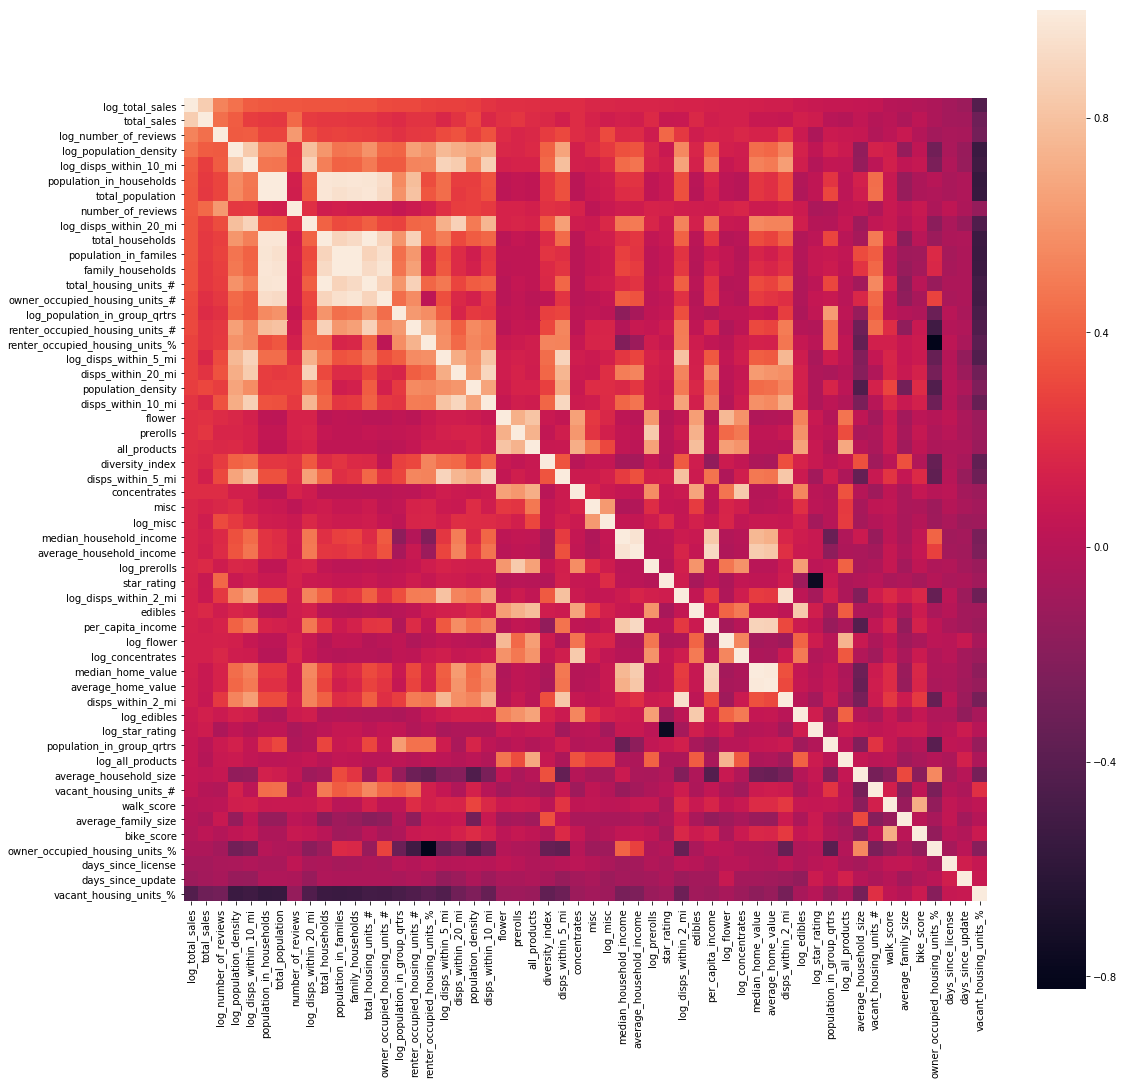

In [1127]:
fig, ax = plt.subplots(figsize=(18,18))
df = numeric.corr().sort_values(by='log_total_sales', ascending=False)
df = df[df.index]
sns.heatmap(df, square=True)

/anaconda3/envs/project2/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<Figure size 432x288 with 0 Axes>

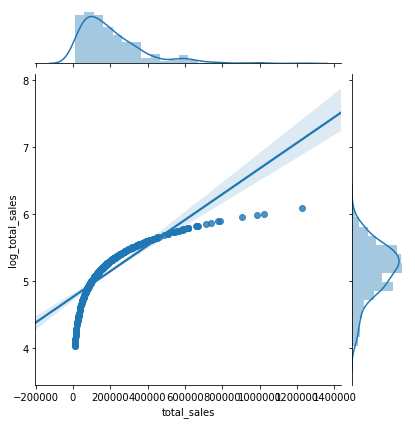

<Figure size 432x288 with 0 Axes>

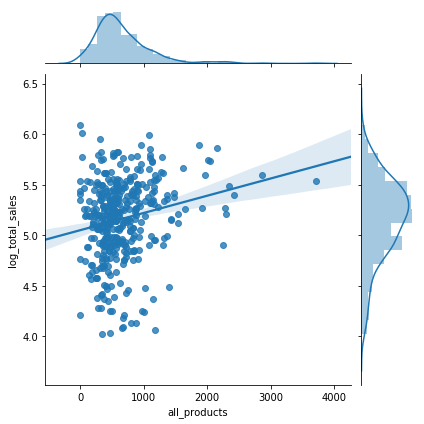

<Figure size 432x288 with 0 Axes>

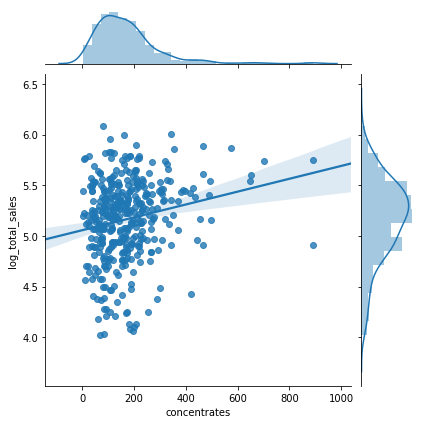

<Figure size 432x288 with 0 Axes>

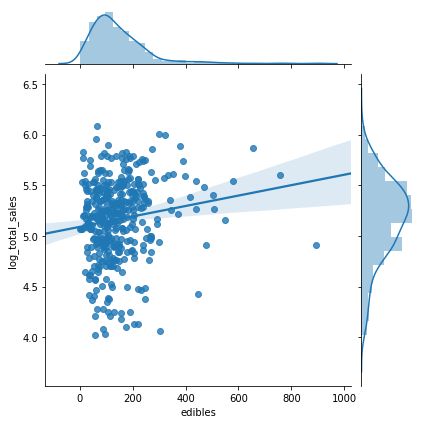

<Figure size 432x288 with 0 Axes>

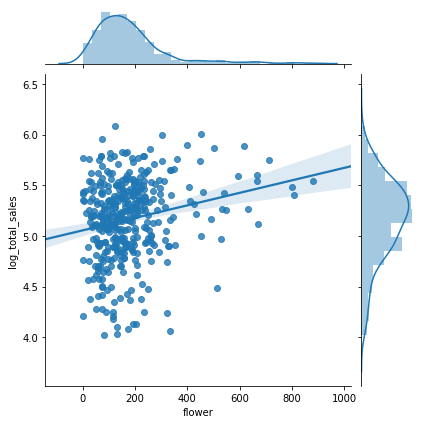

<Figure size 432x288 with 0 Axes>

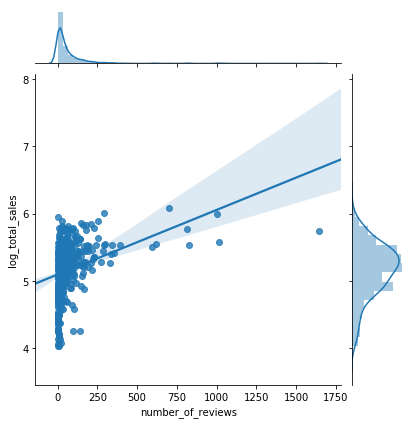

<Figure size 432x288 with 0 Axes>

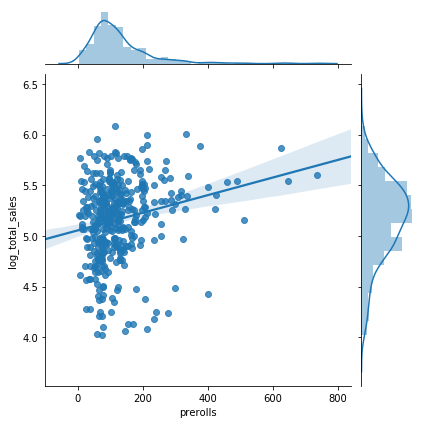

<Figure size 432x288 with 0 Axes>

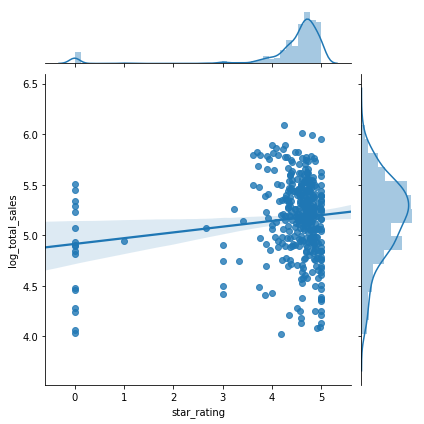

<Figure size 432x288 with 0 Axes>

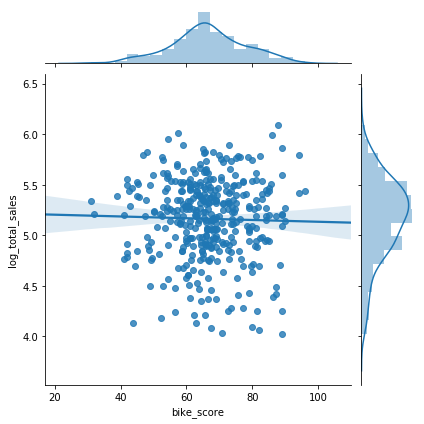

<Figure size 432x288 with 0 Axes>

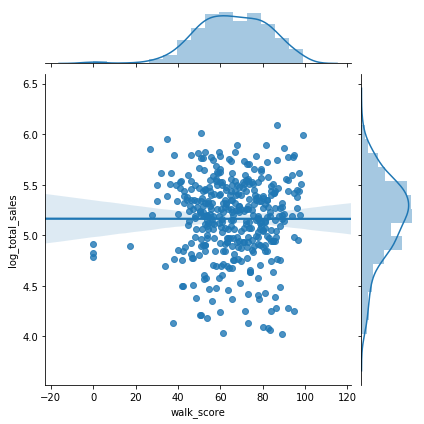

<Figure size 432x288 with 0 Axes>

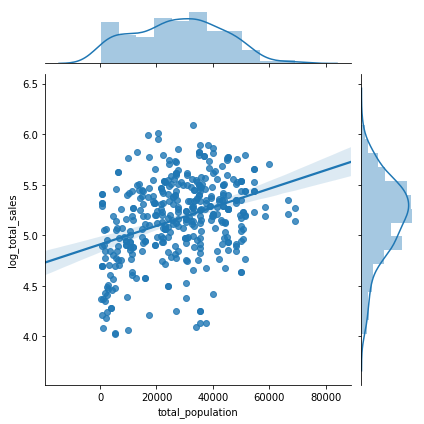

<Figure size 432x288 with 0 Axes>

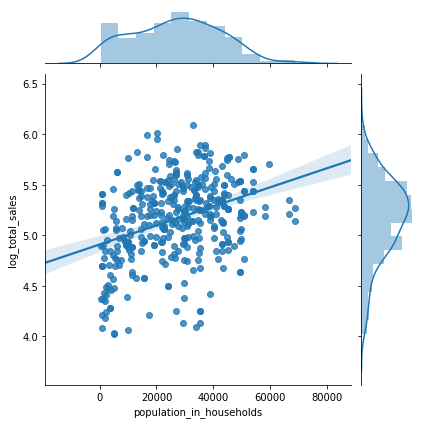

<Figure size 432x288 with 0 Axes>

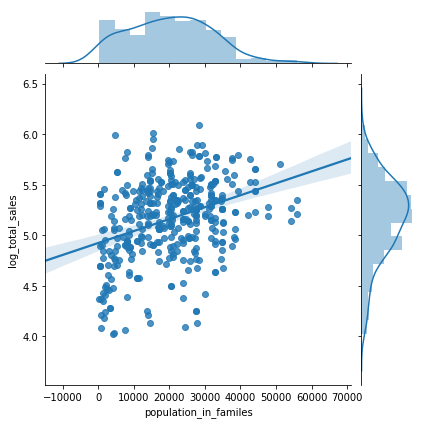

<Figure size 432x288 with 0 Axes>

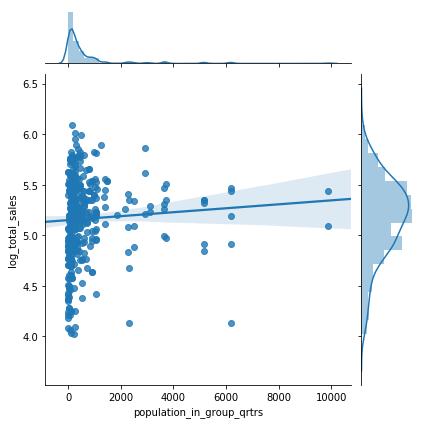

<Figure size 432x288 with 0 Axes>

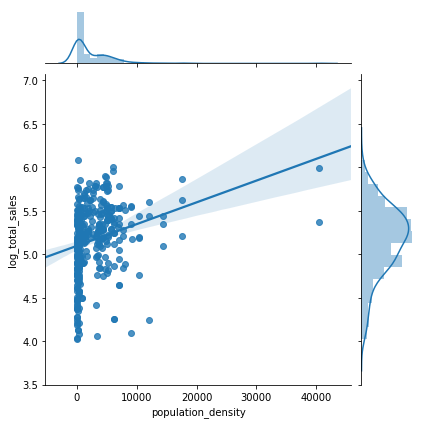

<Figure size 432x288 with 0 Axes>

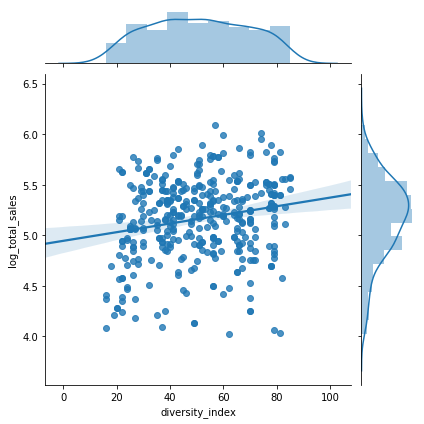

<Figure size 432x288 with 0 Axes>

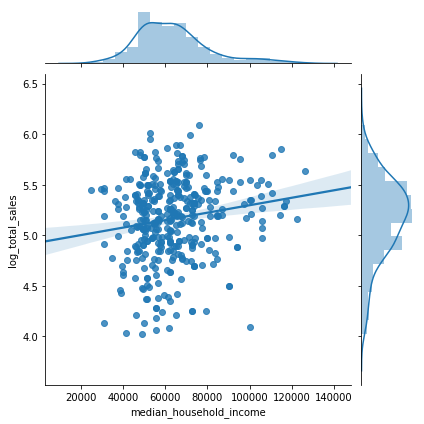

<Figure size 432x288 with 0 Axes>

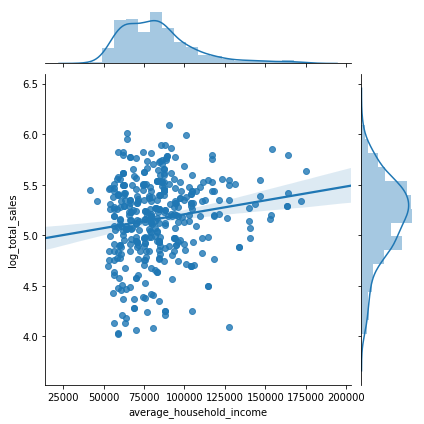

<Figure size 432x288 with 0 Axes>

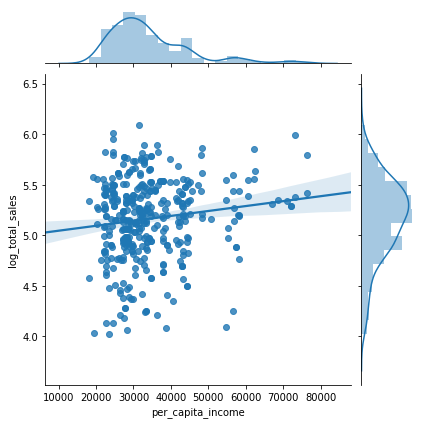

<Figure size 432x288 with 0 Axes>

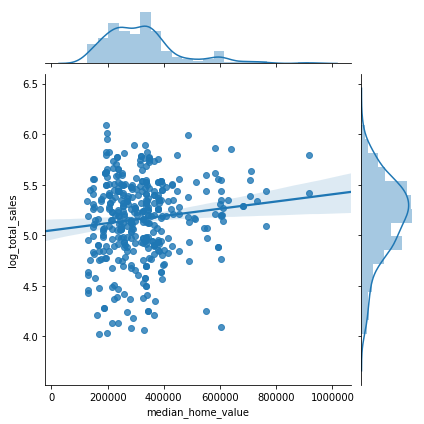

<Figure size 432x288 with 0 Axes>

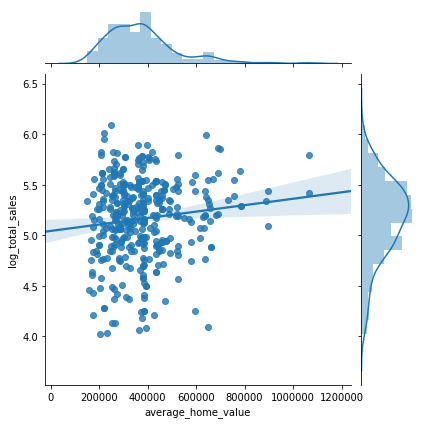

<Figure size 432x288 with 0 Axes>

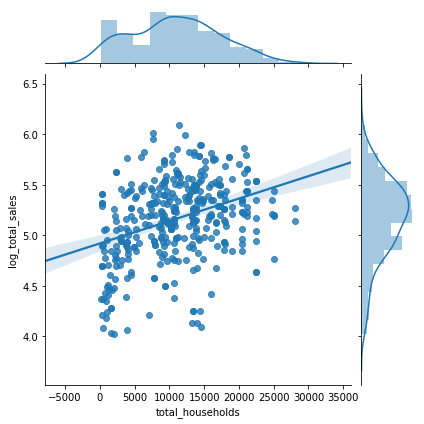

<Figure size 432x288 with 0 Axes>

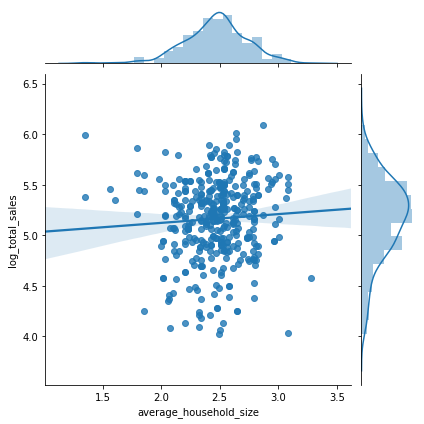

<Figure size 432x288 with 0 Axes>

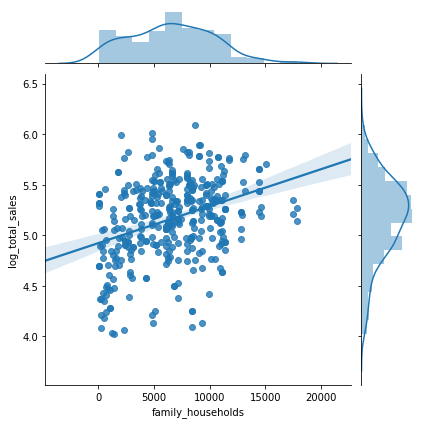

<Figure size 432x288 with 0 Axes>

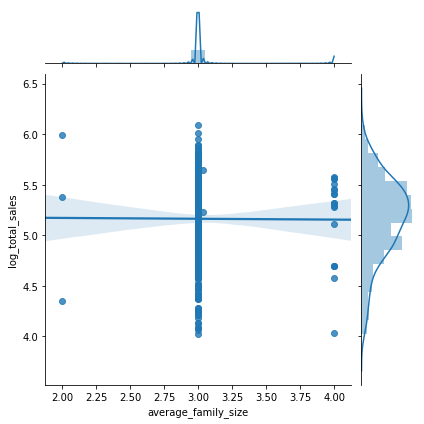

<Figure size 432x288 with 0 Axes>

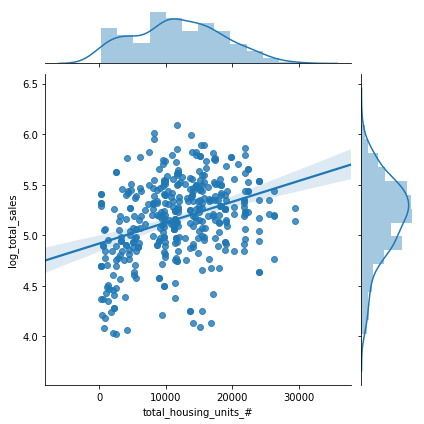

<Figure size 432x288 with 0 Axes>

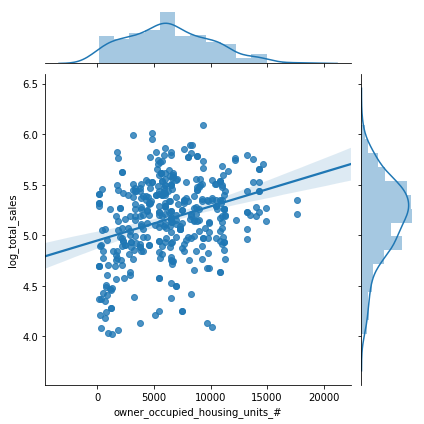

<Figure size 432x288 with 0 Axes>

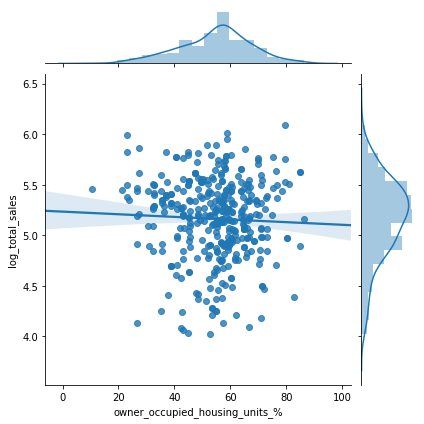

<Figure size 432x288 with 0 Axes>

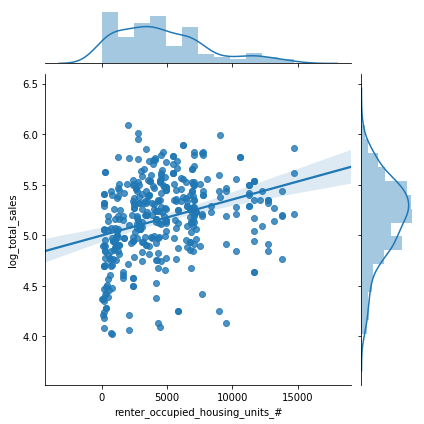

<Figure size 432x288 with 0 Axes>

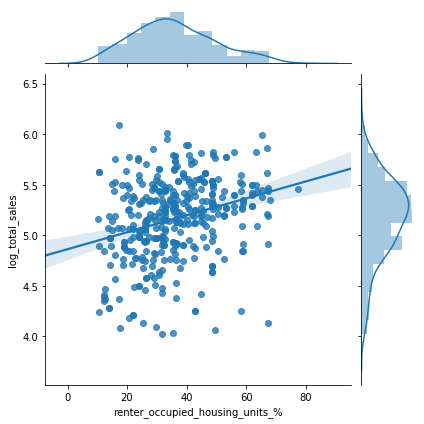

<Figure size 432x288 with 0 Axes>

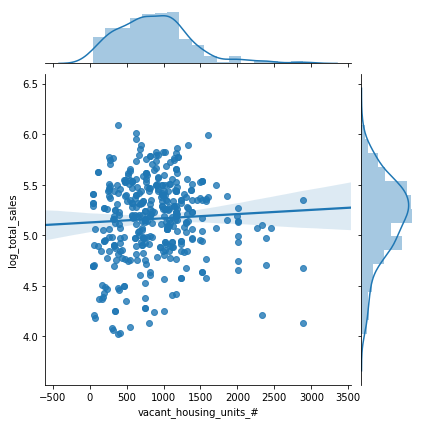

<Figure size 432x288 with 0 Axes>

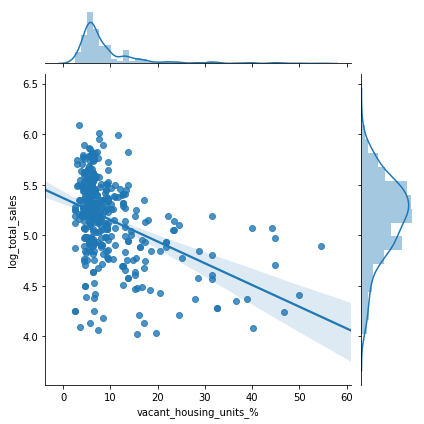

<Figure size 432x288 with 0 Axes>

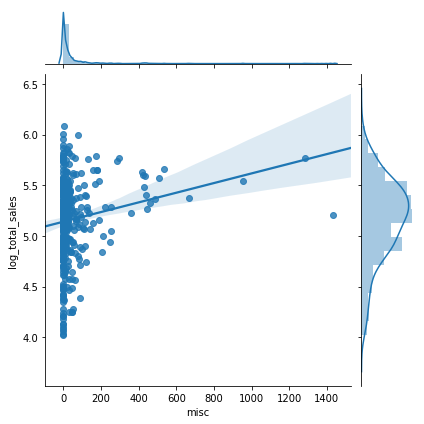

<Figure size 432x288 with 0 Axes>

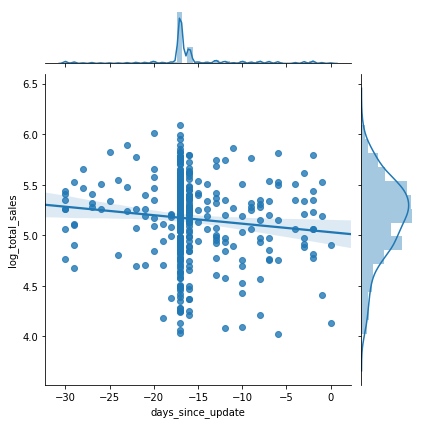

<Figure size 432x288 with 0 Axes>

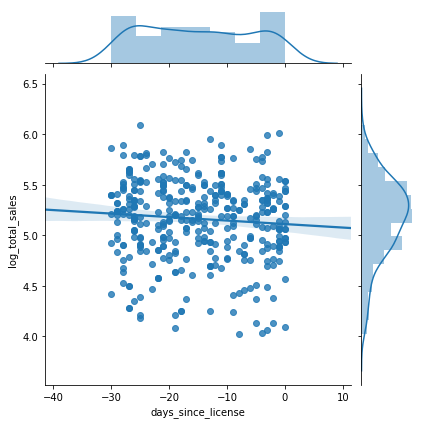

<Figure size 432x288 with 0 Axes>

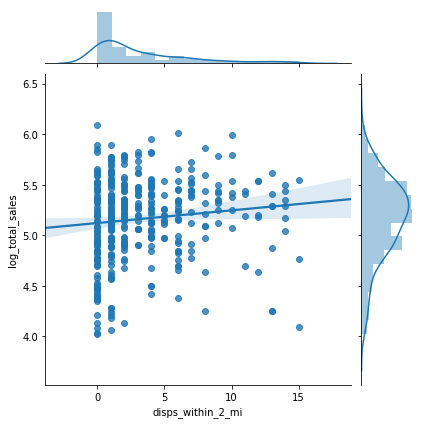

<Figure size 432x288 with 0 Axes>

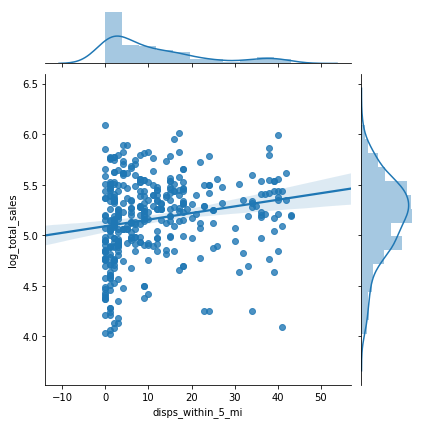

<Figure size 432x288 with 0 Axes>

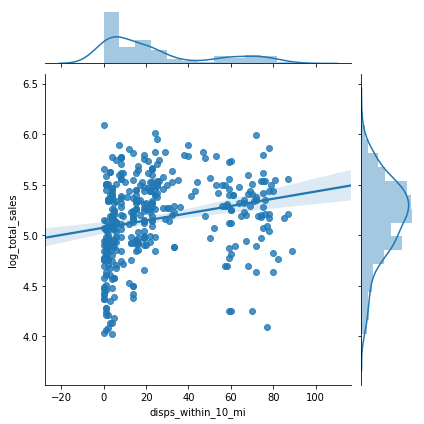

<Figure size 432x288 with 0 Axes>

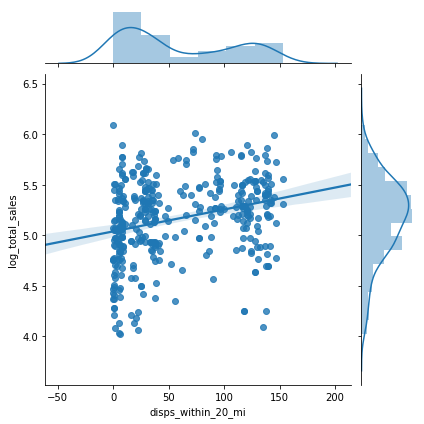

<Figure size 432x288 with 0 Axes>

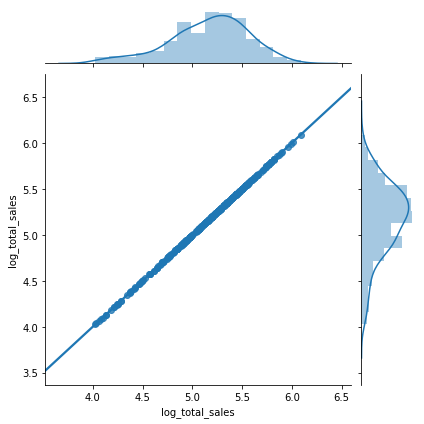

<Figure size 432x288 with 0 Axes>

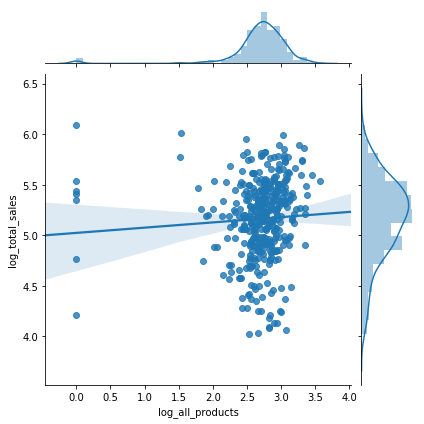

<Figure size 432x288 with 0 Axes>

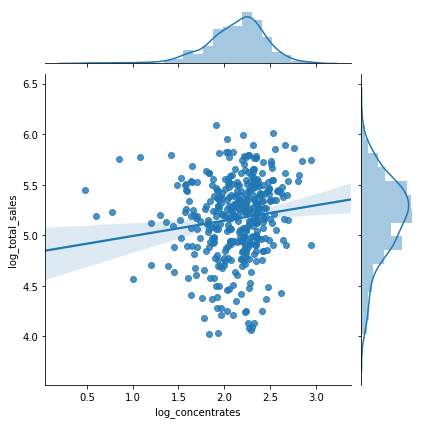

<Figure size 432x288 with 0 Axes>

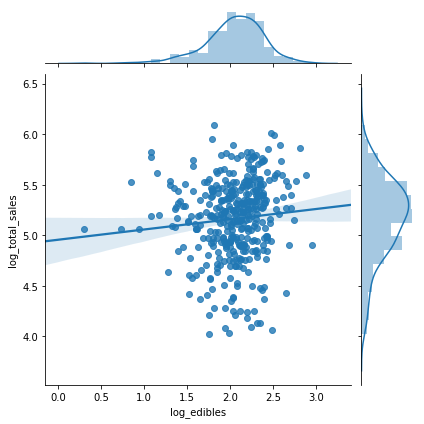

<Figure size 432x288 with 0 Axes>

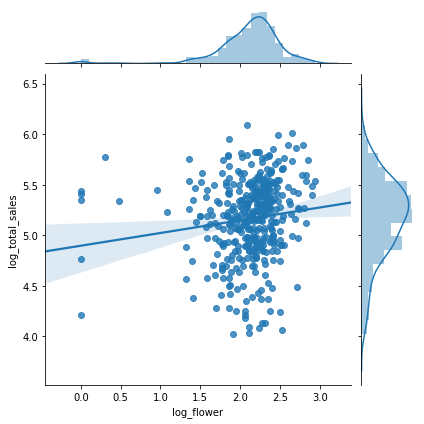

<Figure size 432x288 with 0 Axes>

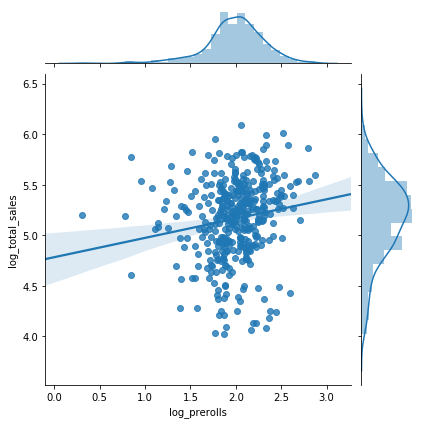

<Figure size 432x288 with 0 Axes>

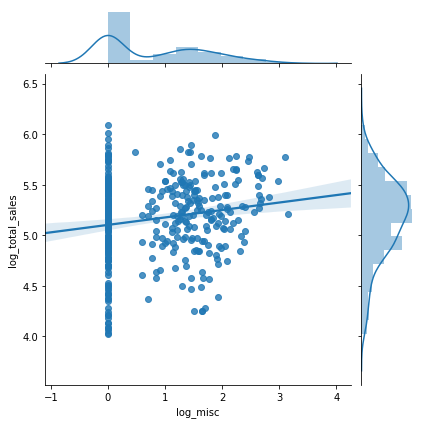

<Figure size 432x288 with 0 Axes>

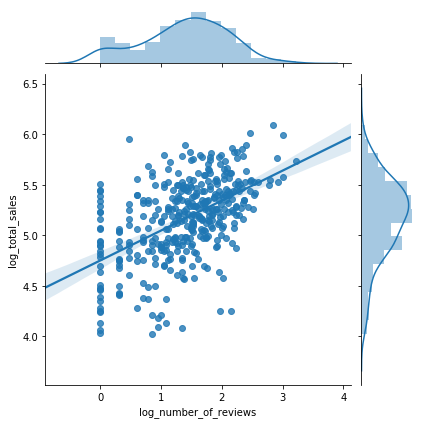

<Figure size 432x288 with 0 Axes>

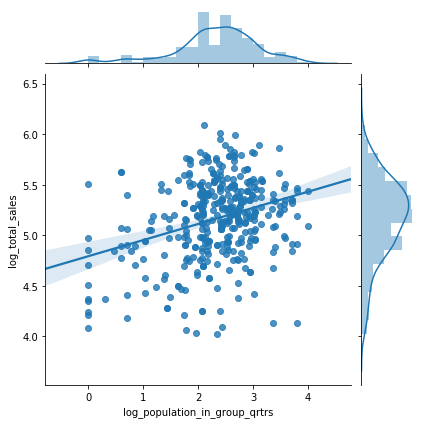

<Figure size 432x288 with 0 Axes>

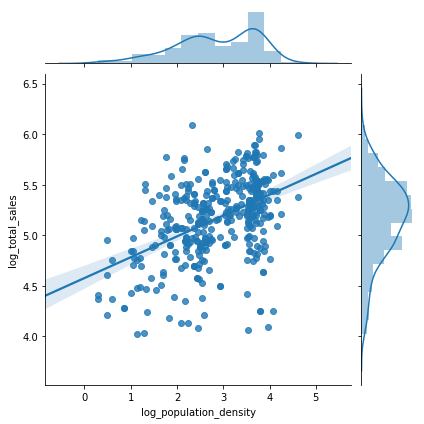

<Figure size 432x288 with 0 Axes>

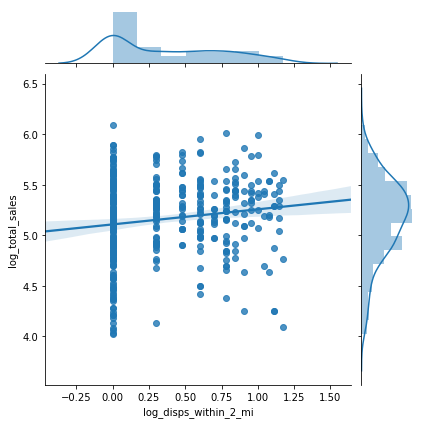

<Figure size 432x288 with 0 Axes>

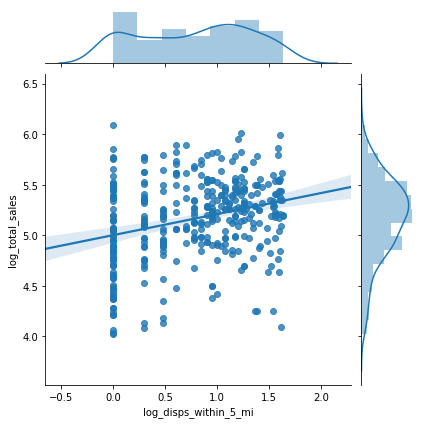

<Figure size 432x288 with 0 Axes>

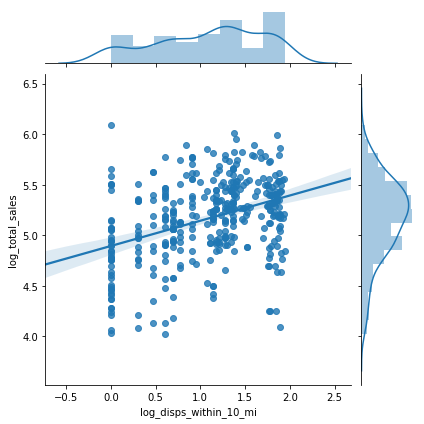

<Figure size 432x288 with 0 Axes>

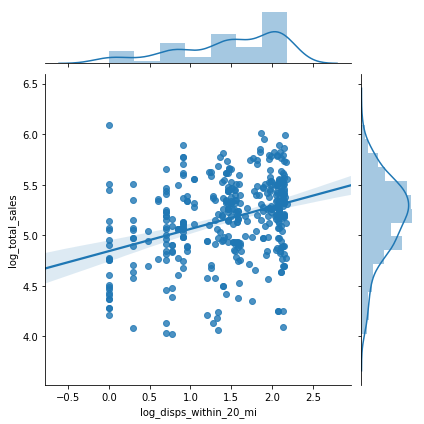

<Figure size 432x288 with 0 Axes>

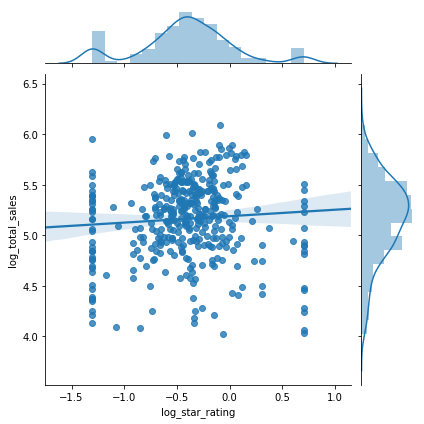

In [1128]:
targets = ['total_sales', 'log_total_sales']

for i, col in enumerate(numeric.columns):   
    f = plt.figure()
    df = numeric.replace([np.inf, -np.inf], np.nan).dropna()
    sns.jointplot(x=col, y=targets[1], kind='reg', height=6, data=df);


*Before moving on to exploratory analysis, write down some notes about challenges encountered while working with this data that might be helpful for anyone else (including yourself) who may work through this later on.*

# Explore the Data

*Before you start exploring the data, write out your thought process about what you're looking for and what you expect to find. Take a minute to confirm that your plan actually makes sense.*

*Calculate summary statistics and plot some charts to give you an idea what types of useful relationships might be in your dataset. Use these insights to go back and download additional data or engineer new features if necessary. Not now though... remember we're still just trying to finish the MVP!*

In [ ]:
## %%writefile ../src/visualization/visualize.py

# imports
# helper functions go here

def run():
    """
    Executes a set of helper functions that read files from 
    data/processed, calculates descriptive statistics for the population,
    and plots charts that visualize interesting relationships between 
    features.
    """
    # data = load_features('data/processed')
    # describe_features(data, 'reports/')
    # generate_charts(data, 'reports/figures/')
    pass


*What did you learn? What relationships do you think will be most helpful as you build your model?*

# Model the Data

*Describe the algorithm or algorithms that you plan to use to train with your data. How do these algorithms work? Why are they good choices for this data and problem space?*

In [1129]:
## %%writefile ../src/models/train_model.py

# Imports
import pickle

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Helper functions

def save_to(item, path):
    """
    Pickles item sand saves it to path
    Input: object to be pickled, string containing directory and filename
    Output: pickled object stored to provided path
    """
    with open(path, 'wb') as to_write:
        pickle.dump(item, to_write)
    return


def load_features(filepath, target):
    """
    
    """
    data = pd.read_pickle(filepath)
    print(target)
#     target = ['log_total_sales']
#     cols = features + target
#     refined_data = data[cols]
    abs_corrs = data.corr()[target].abs().sort_values(by=target, ascending=False)
#     abs_corrs = data.corr()[target].abs().sort_values(ascending=False)
    features = list(abs_corrs[:16].drop(target).index)
    
    cols = features + target
    model_data = data[cols]
    
    return model_data
    
    
def run(results, rand=10):
    """
    Executes a set of helper functions that read files from 
    data/processed, calculates descriptive statistics for the population,
    and plots charts that visualize interesting relationships between 
    features.
    """
    path = '../data/processed/'
    filename = {
        'data': 'data.pkl',
        'train': 'train.pkl',
        'test': 'test.pkl'
    }
    
    targets = ['total_sales', 'log_total_sales']
    target = targets[0]
    
    data = load_features(path + filename['data'], [target])

    X, y = data.drop(targets, axis=1), data[target]

    # Hold out 20% of the data for final testing
    X, X_test, y, y_test = train_test_split(X, y, random_state=rand)
#     save_to(train, path + filename['train'])
#     save_to(test, path + filename['test'])
    
    lm1 = LinearRegression()
    lm1.fit(X, y)
    save_to(lm1, '../models/lm1.pkl')
    return lm1, X, X_test, y, y_test

_Write down any thoughts you may have about working with these algorithms on this data. What other ideas do you want to try out as you iterate on this pipeline?_

# Interpret the Model

_Write up the things you learned, and how well your model performed. Be sure address the model's strengths and weaknesses. What types of data does it handle well? What types of observations tend to give it a hard time? What future work would you or someone reading this might want to do, building on the lessons learned and tools developed in this project?_

In [1079]:
data = pd.read_pickle('../data/processed/data.pkl')
data.head()

,total_sales,ada_accessible,all_products,atm,concentrates,debit_cards_accepted,edibles,flower,medical,number_of_reviews,prerolls,recreational,star_rating,storefront,ufcw_discount,veteran_discount,bike_score,walk_score,transit_score,total_population,population_in_households,population_in_familes,population_in_group_qrtrs,population_density,diversity_index,...,leafly_menu,debit_available,discounts,misc,days_since_update,days_since_license,disps_within_2_mi,disps_within_5_mi,disps_within_10_mi,disps_within_20_mi,log_total_sales,log_all_products,log_concentrates,log_edibles,log_flower,log_prerolls,log_misc,log_number_of_reviews,log_population_in_group_qrtrs,log_population_density,log_disps_within_2_mi,log_disps_within_5_mi,log_disps_within_10_mi,log_disps_within_20_mi,log_star_rating
name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
The Herbery - Chkalov,409174.053333,True,1308.0,True,466.0,False,351.0,236.0,False,19.0,191.0,True,4.389474,True,False,False,NaN,NaN,NaN,30890.0,30822.0,25773.0,68.0,4366.0,50.0,...,True,True,False,64.0,-17.0,-11.0,1,4,8,8,5.611908,3.116608,2.668386,2.545307,2.372912,2.281033,1.806180,1.278754,1.832509,3.640084,0.000000,0.602060,0.903090,0.903090,-0.214296
Pend Oreille Cannabis Co.,23546.333333,True,367.0,True,73.0,True,44.0,181.0,False,12.0,64.0,True,5.000000,True,False,True,NaN,NaN,NaN,1045.0,1045.0,828.0,0.0,4.0,16.0,...,True,True,True,5.0,-16.0,-17.0,0,0,0,0,4.371923,2.564666,1.863323,1.643453,2.257679,1.806180,0.698970,1.079181,-inf,0.602060,-inf,-inf,-inf,-inf,-inf
Pot Shop Seattle,222612.420000,False,522.0,False,149.5,False,93.0,134.5,False,22.0,65.0,True,4.700000,True,False,False,69.000000,82.000000,NaN,27127.0,26279.0,10541.0,848.0,14311.0,49.0,...,False,False,False,0.0,-2.0,-7.0,9,42,72,142,5.347549,2.717671,2.174641,1.968483,2.128722,1.812913,-inf,1.342423,2.928396,4.155670,0.954243,1.623249,1.857332,2.152288,-0.522879
Fillabong 2 - Bremerton,132870.320000,True,677.0,True,226.0,False,142.0,88.0,True,18.0,66.0,True,4.870370,True,False,True,70.857143,78.571429,NaN,20140.0,19803.0,14090.0,337.0,3380.0,56.0,...,True,True,True,155.0,-17.0,-12.0,4,14,19,91,5.123428,2.830589,2.354108,2.152288,1.944483,1.819544,2.190332,1.255273,2.527630,3.528917,0.602060,1.146128,1.278754,1.959041,-0.887296
Green Tiki Cannabis Co,71831.986667,True,924.0,True,174.5,False,238.5,129.5,False,10.0,92.5,True,3.963333,True,False,True,72.714286,75.142857,NaN,10487.0,10487.0,8678.0,0.0,344.0,38.0,...,False,True,True,0.0,-7.0,-22.0,0,0,6,111,4.856318,2.965672,2.241795,2.377488,2.112270,1.966142,-inf,1.000000,-inf,2.536558,-inf,-inf,0.778151,2.045323,0.015639


In [246]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import regression

In [1154]:
columns = ['Model', '# Features', 'Target', 
           'Train R^2', 'Test R^2', 'MSE', 'RMSE']
record = pd.DataFrame(columns=columns)
record

,Model,# Features,Target,Train R^2,Test R^2,MSE,RMSE


In [1147]:
lm1.get_params(deep=True)

{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False}

In [ ]:
lm1, X, X_test, y, y_test = run(results, rand=12)

In [1163]:
print('Model Performance\n')
Rs = pd.DataFrame({'R^2': [lm1.score(X, y), lm1.score(X_test, y_test)]})
Rs.index = ['Train', 'Test']
display(Rs)

results = {
    'Model': 'lm1', 
    '# Features': len(X.columns), 
    'Target': target, 
    'Train R^2': lm1.score(X, y), 
    'Test R^2': lm1.score(X_test, y_test), 
    'MSE': mean_squared_error(y_test, y_pred), 
    'RMSE': mean_squared_error(y_test, y_pred)**.5
}
# results.update(dict(zip(X.columns, lm1.coef_)))
# results = pd.DataFrame(results, index=range(len(record)))
display(results)
record.loc[len(record)] = results
# record.append(results)
record

Model Performance



,R^2
Train,0.424226
Test,0.151577


{'Model': 'lm1',
 '# Features': 14,
 'Target': 'log_total_sales',
 'Train R^2': 0.4242256711109702,
 'Test R^2': 0.15157701138976543,
 'MSE': 34278663884.34784,
 'RMSE': 185144.98071605354}

,Model,# Features,Target,Train R^2,Test R^2,MSE,RMSE
0,lm1,14,log_total_sales,0.424226,0.151577,3.427866e+10,185144.980716


['total_sales']
['total_sales']
['total_sales']
['total_sales']
['total_sales']
['total_sales']
['total_sales']
['total_sales']
['total_sales']
['total_sales']
['total_sales']
['total_sales']
['total_sales']
['total_sales']
['total_sales']
['total_sales']
['total_sales']
['total_sales']
['total_sales']
['total_sales']
['total_sales']
['total_sales']
['total_sales']
['total_sales']
['total_sales']
['total_sales']
['total_sales']
['total_sales']
['total_sales']
['total_sales']
['total_sales']
['total_sales']
['total_sales']
['total_sales']
['total_sales']
['total_sales']
['total_sales']
['total_sales']
['total_sales']
['total_sales']
['total_sales']
['total_sales']
['total_sales']
['total_sales']
['total_sales']
['total_sales']
['total_sales']
['total_sales']
['total_sales']
['total_sales']
Model Performance:



,Features,Coefficients
0,log_number_of_reviews,57747.568204
1,number_of_reviews,312.131858
2,log_population_density,61629.563373
3,vacant_housing_units_%,-5129.763695
4,population_density,3.383156
5,log_disps_within_10_mi,-139072.018450
6,log_disps_within_20_mi,30655.690981
7,population_in_households,-24.600168
8,total_population,3.156344
9,population_in_familes,25.162897


Text(0, 0.5, 'R^2')

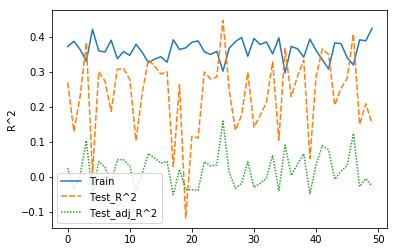

In [1150]:
train_r = []
test_r = []
test_adj_r = []

for t in range(50):
    lm1, X, X_test, y, y_test = run(rand=t)
    train_r.append(lm1.score(X, y))
    R = lm1.score(X_test, y_test)
    test_r.append(R)
    y_pred = lm1.predict(X_test)
    n = len(X)
    p = len(X.columns)
    adj_r2 = 1 - (1-R**2)*(n-1)/(n-p-1)
    test_adj_r.append(adj_r2)
    
print('Model Performance:\n')
display(pd.DataFrame({'Features': list(X.columns), 'Coefficients': list(lm1.coef_)}))

Rs = pd.DataFrame({'Train': train_r, 'Test_R^2': test_r, 'Test_adj_R^2': test_adj_r})
# display(Rs)

# Rs.plot()
sns.lineplot(data=Rs)
plt.ylabel('R^2')

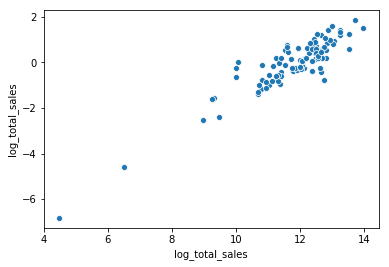

In [755]:
sns.scatterplot(y_test, y_test - y_pred);
# sns.resid

In [758]:
y_test.describe()

count    98.000000
mean     11.809942
std       1.354386
min       4.481872
25%      11.317141
50%      12.086409
75%      12.632537
max      13.978051
Name: log_total_sales, dtype: float64

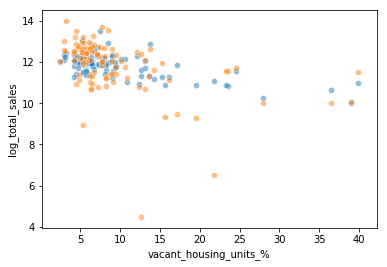

In [751]:
sns.scatterplot(X_test['vacant_housing_units_%'], y_pred, alpha=0.5)
sns.scatterplot(X_test['vacant_housing_units_%'], y_test, alpha=0.5)

In [752]:
mean_squared_error(y_test, y_pred)**.5

1.1722773830890783

In [753]:
mean_squared_error(y_test, y_pred)**.5 / (sum(y_test)/len(y_test))

0.09926190799473537